# Flatiron Health mBC: Machine learning models with crude imputation 

**OBJECTIVE: Build 4 survival machine learning models using a crude imputation strategy. This imputation strategy assumes data is missing completely at random and will impute median for numerical variables and leave missing categorical entries as "unknown" (eg., possible ECOG values are 0, 1, 2, 3, 4, 5, and unknown).**

**BACKGROUND: The models were built using scikit-survival which is a machine learning library for survival analysis.  All 4 of these machine learning models are intended for survival analysis and so take into account censored data.** 

**Time-dependent area under the receiver operator curve (AUC) at 2 years from metasttic diagnosis was selected as the primary performance metric. This metric determines how well a model can distinguish patients who die by time *t* from patients who die after this time.**

**OUTLINE:**
1. **Preprocessing**
2. **Gradient boosted model** 
3. **Random survival forest** 
4. **Penalized Cox models**
5. **Linear support vector machine** 

## 1. Preprocessing 

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer 

### 1.1 Importing full dataframes

In [2]:
# Import training set and set PatientID as index.
train = pd.read_csv('train_full.csv', index_col = 'PatientID')
print(len(train), train.index.is_unique)

25341 True


In [3]:
# Import test set and set PatientID as index.
test = pd.read_csv('test_full.csv', index_col = 'PatientID')
print(len(test), test.index.is_unique)

6336 True


### 1.2 Converting datatypes 

In [4]:
list(train.select_dtypes(include = ['object']).columns)

['gender',
 'race',
 'ethnicity',
 'p_type',
 'region',
 'stage',
 'ER',
 'HER2',
 'PR',
 'BRCA',
 'PIK3CA',
 'pdl1_n',
 'ecog_diagnosis']

In [5]:
to_be_categorical = list(train.select_dtypes(include = ['object']).columns)

In [6]:
to_be_categorical.append('met_year')

In [7]:
to_be_categorical.append('ses')

In [8]:
# Convert variables in list to categorical.
for x in list(to_be_categorical):
    train[x] = train[x].astype('category')

In [9]:
list(train.select_dtypes(include = ['category']).columns)

['gender',
 'race',
 'ethnicity',
 'p_type',
 'region',
 'stage',
 'met_year',
 'ER',
 'HER2',
 'PR',
 'BRCA',
 'PIK3CA',
 'pdl1_n',
 'ecog_diagnosis',
 'ses']

In [10]:
# Convert variables in list to categorical.
for x in list(to_be_categorical):
    test[x] = test[x].astype('category')

In [11]:
# Convert death_status into True or False (required for scikit-survival). 
train['death_status'] = train['death_status'].astype('bool')

In [12]:
# Convert death_status into True or False (required for scikit-survival).
test['death_status'] = test['death_status'].astype('bool')

### 1.3 Defining validation set

**A validation dataset will be constructed from the training set. This validation set will comprise of 25% of the training set. It will be used to assist in early stopping for the gradient boosted survival model and the random survival model. Like in the training-test split, a stratified approach will be carried out to preserve the distribution of diagnosis years.**   

In [13]:
train['met_year_cat'] = pd.cut(train['met_year'],
                               bins = [2010, 2012, 2014, 2016, 2018, 2020, 2022],
                               labels = ['11-12', '13-14', '15-16', '17-18', '19-20', '21-22'])

In [14]:
sss = StratifiedShuffleSplit(n_splits = 1, test_size = 0.25, random_state = 42)

for sub_train_index, val_index in sss.split(train, train['met_year_cat']):
    sub_train = train.iloc[sub_train_index]
    val = train.iloc[val_index]

In [15]:
train = train.drop(columns = ['met_year_cat'])

In [16]:
sub_train = sub_train.drop(columns = ['met_year_cat'])

In [17]:
val = val.drop(columns = ['met_year_cat'])

In [18]:
pd.DataFrame(val.index, columns = ['PatientID']).to_csv('val_IDs.csv', index = False, header = True)

In [19]:
val_IDs = pd.read_csv('val_IDs.csv')

### 1.4 Separate into X and Y

In [20]:
# 'X' datasets
train_x = train.drop(columns = ['death_status', 'timerisk_activity']) #80% of data 

test_x = test.drop(columns = ['death_status', 'timerisk_activity']) #20% of data 

sub_train_x = sub_train.drop(columns = ['death_status', 'timerisk_activity']) #60% of data

val_x = val.drop(columns = ['death_status', 'timerisk_activity']) #20% of data 

In [21]:
# 'Y' datasets
# Death status and time until event needs to be stored as a structured array to be compatible with scikit-survival
y_dtypes = train[['death_status', 'timerisk_activity']].dtypes

train_y = np.array([tuple(x) for x in train[['death_status', 'timerisk_activity']].values], 
                   dtype = list(zip(y_dtypes.index, y_dtypes)))

test_y = np.array([tuple(x) for x in test[['death_status', 'timerisk_activity']].values], 
                  dtype = list(zip(y_dtypes.index, y_dtypes)))

sub_train_y = np.array([tuple(x) for x in sub_train[['death_status', 'timerisk_activity']].values],
                       dtype = list(zip(y_dtypes.index, y_dtypes)))

val_y = np.array([tuple(x) for x in val[['death_status', 'timerisk_activity']].values],
                 dtype = list(zip(y_dtypes.index, y_dtypes)))

### 1.5 Build pipeline

In [22]:
list(train_x.select_dtypes(exclude = ['category']).columns)

['age',
 'delta_met_diagnosis',
 'steroid_diag',
 'opioid_PO_diag',
 'nonopioid_PO_diag',
 'pain_IV_diag',
 'ac_diag',
 'antiinfective_IV_diag',
 'antiinfective_diag',
 'antihyperglycemic_diag',
 'ppi_diag',
 'antidepressant_diag',
 'bta_diag',
 'thyroid_diag',
 'is_diag',
 'medicare',
 'medicaid',
 'medicare_medicaid',
 'commercial',
 'patient_assistance',
 'other_govt',
 'self_pay',
 'other',
 'weight_diag',
 'bmi_diag',
 'bmi_diag_na',
 'weight_pct_change',
 'weight_pct_na',
 'weight_slope',
 'albumin_diag',
 'alp_diag',
 'alt_diag',
 'ast_diag',
 'bicarb_diag',
 'bun_diag',
 'calcium_diag',
 'chloride_diag',
 'creatinine_diag',
 'hemoglobin_diag',
 'neutrophil_count_diag',
 'platelet_diag',
 'potassium_diag',
 'sodium_diag',
 'total_bilirubin_diag',
 'wbc_diag',
 'albumin_diag_na',
 'alp_diag_na',
 'alt_diag_na',
 'ast_diag_na',
 'bicarb_diag_na',
 'bun_diag_na',
 'calcium_diag_na',
 'chloride_diag_na',
 'creatinine_diag_na',
 'hemoglobin_diag_na',
 'neutrophil_count_diag_na',
 'pl

In [23]:
# List of numeric variables, excluding binary variables. 
numerical_features = [
    'age',
    'delta_met_diagnosis',
    'weight_diag',
    'bmi_diag',
    'weight_pct_change',
    'weight_slope',
    'albumin_diag',
    'alp_diag',
    'alt_diag',
    'ast_diag',
    'bicarb_diag',
    'bun_diag',
    'calcium_diag',
    'chloride_diag',
    'creatinine_diag',
    'hemoglobin_diag',
    'neutrophil_count_diag',
    'platelet_diag',
    'potassium_diag',
    'sodium_diag',
    'total_bilirubin_diag',
    'wbc_diag', 
    'albumin_avg',
    'alp_avg',
    'alt_avg',
    'ast_avg',
    'bicarb_avg',
    'bun_avg',
    'calcium_avg',
    'chloride_avg',
    'creatinine_avg',
    'hemoglobin_avg',
    'neutrophil_count_avg',
    'platelet_avg',
    'potassium_avg',
    'sodium_avg',
    'total_bilirubin_avg',
    'wbc_avg',
    'albumin_max',
    'alp_max',
    'alt_max',
    'ast_max',
    'bicarb_max',
    'bun_max',
    'calcium_max',
    'chloride_max',
    'creatinine_max',
    'hemoglobin_max',
    'neutrophil_count_max',
    'platelet_max',
    'potassium_max',
    'sodium_max',
    'total_bilirubin_max',
    'wbc_max',
    'albumin_min',
    'alp_min',
    'alt_min',
    'ast_min',
    'bicarb_min',
    'bun_min',
    'calcium_min',
    'chloride_min',
    'creatinine_min',
    'hemoglobin_min',
    'neutrophil_count_min',
    'platelet_min',
    'potassium_min',
    'sodium_min',
    'total_bilirubin_min',
    'wbc_min',
    'albumin_std',
    'alp_std',
    'alt_std',
    'ast_std',
    'bicarb_std',
    'bun_std',
    'calcium_std',
    'chloride_std',
    'creatinine_std',
    'hemoglobin_std',
    'neutrophil_count_std',
    'platelet_std',
    'potassium_std',
    'sodium_std',
    'total_bilirubin_std',
    'wbc_std',
    'albumin_slope',
    'alp_slope',
    'alt_slope',
    'ast_slope',
    'bicarb_slope',
    'bun_slope',
    'calcium_slope',
    'chloride_slope',
    'creatinine_slope',
    'hemoglobin_slope',
    'neutrophil_count_slope',
    'platelet_slope',
    'potassium_slope',
    'sodium_slope',
    'total_bilirubin_slope',
    'wbc_slope',
    'icd_count']

# Transformer will first calculate column median and impute, and then apply a standard scaler. 
numerical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('std_scaler', StandardScaler())])

In [24]:
list(train_x.select_dtypes(include = ['category']).columns)

['gender',
 'race',
 'ethnicity',
 'p_type',
 'region',
 'stage',
 'met_year',
 'ER',
 'HER2',
 'PR',
 'BRCA',
 'PIK3CA',
 'pdl1_n',
 'ecog_diagnosis',
 'ses']

In [25]:
# List of categorical features.
categorical_features = list(train_x.select_dtypes(include = ['category']).columns)

# One-hot-encode categorical features.
categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')

In [26]:
# Remaining unprocessed columns which are binary variables
len(train_x.columns) - (len(numerical_features) + len(categorical_features))

96

In [27]:
all_columns = list(train_x.columns)

In [28]:
# Prints number of columns after removing columns that are numerical or categorical. 
for i in list(numerical_features + categorical_features):
    all_columns.remove(i)
len(all_columns)

96

In [29]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)],
    remainder = 'passthrough')

## 2. Gradient boosted survival model

In [30]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import StratifiedKFold, HalvingGridSearchCV
from sklearn.pipeline import make_pipeline

from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.metrics import cumulative_dynamic_auc, as_cumulative_dynamic_auc_scorer

from joblib import dump, load 

import matplotlib.pyplot as plt

import warnings 

**The gradient boosted survival model will be configured by setting a low learning rate (eg., <= 0.1) and choosing the number of trees by monitoring the 1 year AUC on the valdiation dataset and stopping once performance on the validation dataset begins to degrade. The learning rate will be tuned to achieve a target tree size >500. Once learning rate and tree number are set, a halving grid search with 3-fold cross validation will be performed to identify ideal max depth and subsample percentage.**  

### 2.1 Determining number of trees for full model 

**The full model includes all variables, notably 96 summary labs values which have significant missingness (>40%).**

In [31]:
sub_train_xt = preprocessor.fit_transform(sub_train_x)
val_xt = preprocessor.transform(val_x)

gbm_exp = GradientBoostingSurvivalAnalysis(n_estimators = 1500,
                                           learning_rate = 0.05,
                                           max_depth = 3,
                                           subsample = 0.75,
                                           verbose = 1,
                                           random_state = 42)

gbm_exp.fit(sub_train_xt, sub_train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       71340.2000          13.2750          147.97m
         2       71620.0992          12.2278          149.90m
         3       71401.4880          11.8653          146.48m
         4       71568.6098          12.4254          147.25m
         5       72094.2357          10.8584          146.53m
         6       71545.2219          10.5679          145.28m
         7       71643.9361          10.3981          144.56m
         8       71104.5878           9.8123          143.30m
         9       71565.2848           9.3862          144.13m
        10       70947.6604           9.3162          144.79m
        20       71507.7809           6.8999          139.63m
        30       70220.1291           5.2495          144.07m
        40       70448.0568           3.9264          146.46m
        50       70450.9198           4.4015          147.09m
        60       70324.6009           3.5187          146.98m
       

GradientBoostingSurvivalAnalysis(learning_rate=0.05, n_estimators=1500,
                                 random_state=42, subsample=0.75, verbose=1)

In [32]:
gbm_staged_auc = [cumulative_dynamic_auc(sub_train_y, val_y, risk_score, 730)[0][0] 
                  for risk_score in gbm_exp.staged_predict(val_xt)]

In [33]:
gbm_staged_auc_tr = [cumulative_dynamic_auc(sub_train_y, sub_train_y, risk_score, 730)[0][0] 
                     for risk_score in gbm_exp.staged_predict(sub_train_xt)]

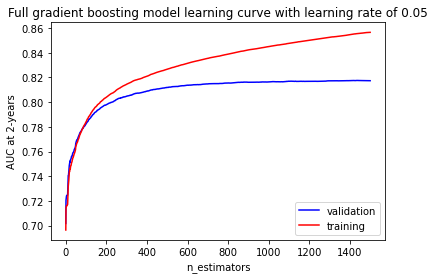

In [34]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

x = range(len(gbm_staged_auc))
plt.plot(x, gbm_staged_auc, color = 'blue', label = 'validation')
plt.plot(x, gbm_staged_auc_tr, color = 'red', label = 'training')
plt.legend(loc = 'lower right')

plt.xlabel("n_estimators")
plt.ylabel("AUC at 2-years")
plt.title('Full gradient boosting model learning curve with learning rate of 0.05')

plt.show()

In [35]:
# Average AUC for every 25 additional trees. 
mean_auc_list = []
for x in np.arange(0, len(gbm_staged_auc), 25):
    mean_auc_list.append(np.mean(gbm_staged_auc[x:x+24]))

In [36]:
print('Number of trees where 2 year AUC on validation dataset beings to downgrade:', np.where(np.diff(mean_auc_list) < 0)[0][0]*25)
print('Validation dataset AUC before degrading:', gbm_staged_auc[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])
print('Training dataset AUC before degrading:', gbm_staged_auc_tr[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])

Number of trees where 2 year AUC on validation dataset beings to downgrade: 875
Validation dataset AUC before degrading: 0.8161950256552495
Training dataset AUC before degrading: 0.8414979881133863


### 2.2 Determining number of trees for sparse model 

**The sparse model includes a subset of the summary lab values that are considered clinically relevant. Performance will be compared to the full model.**

In [37]:
all_labs = [
    'albumin_diag',
    'alp_diag',
    'alt_diag',
    'ast_diag',
    'bicarb_diag',
    'bun_diag',
    'calcium_diag',
    'chloride_diag',
    'creatinine_diag',
    'hemoglobin_diag',
    'neutrophil_count_diag',
    'platelet_diag',
    'potassium_diag',
    'sodium_diag',
    'total_bilirubin_diag',
    'wbc_diag',
    'albumin_diag_na',
    'alp_diag_na',
    'alt_diag_na',
    'ast_diag_na',
    'bicarb_diag_na',
    'bun_diag_na',
    'calcium_diag_na',
    'chloride_diag_na',
    'creatinine_diag_na',
    'hemoglobin_diag_na',
    'neutrophil_count_diag_na',
    'platelet_diag_na',
    'potassium_diag_na',
    'sodium_diag_na',
    'total_bilirubin_diag_na',
    'wbc_diag_na',
    'albumin_avg',
    'alp_avg',
    'alt_avg',
    'ast_avg',
    'bicarb_avg',
    'bun_avg',
    'calcium_avg',
    'chloride_avg',
    'creatinine_avg',
    'hemoglobin_avg',
    'neutrophil_count_avg',
    'platelet_avg',
    'potassium_avg',
    'sodium_avg',
    'total_bilirubin_avg',
    'wbc_avg',
    'albumin_max',
    'alp_max',
    'alt_max',
    'ast_max',
    'bicarb_max',
    'bun_max',
    'calcium_max',
    'chloride_max',
    'creatinine_max',
    'hemoglobin_max',
    'neutrophil_count_max',
    'platelet_max',
    'potassium_max',
    'sodium_max',
    'total_bilirubin_max',
    'wbc_max',
    'albumin_min',
    'alp_min',
    'alt_min',
    'ast_min',
    'bicarb_min',
    'bun_min',
    'calcium_min',
    'chloride_min',
    'creatinine_min',
    'hemoglobin_min',
    'neutrophil_count_min',
    'platelet_min',
    'potassium_min',
    'sodium_min',
    'total_bilirubin_min',
    'wbc_min',
    'albumin_std',
    'alp_std',
    'alt_std',
    'ast_std',
    'bicarb_std',
    'bun_std',
    'calcium_std',
    'chloride_std',
    'creatinine_std',
    'hemoglobin_std',
    'neutrophil_count_std',
    'platelet_std',
    'potassium_std',
    'sodium_std',
    'total_bilirubin_std',
    'wbc_std',
    'albumin_slope',
    'alp_slope',
    'alt_slope',
    'ast_slope',
    'bicarb_slope',
    'bun_slope',
    'calcium_slope',
    'chloride_slope',
    'creatinine_slope',
    'hemoglobin_slope',
    'neutrophil_count_slope',
    'platelet_slope',
    'potassium_slope',
    'sodium_slope',
    'total_bilirubin_slope',
    'wbc_slope',
    'albumin_slope_na',
    'alp_slope_na',
    'alt_slope_na',
    'ast_slope_na',
    'bicarb_slope_na',
    'bun_slope_na',
    'calcium_slope_na',
    'chloride_slope_na',
    'creatinine_slope_na',
    'hemoglobin_slope_na',
    'neutrophil_count_slope_na',
    'platelet_slope_na',
    'potassium_slope_na',
    'sodium_slope_na',
    'total_bilirubin_slope_na',
    'wbc_slope_na']

In [38]:
keep_labs = [
    'albumin_diag',
    'alp_diag',
    'alt_diag',
    'ast_diag',
    'bicarb_diag',
    'bun_diag',
    'calcium_diag',
    'chloride_diag',
    'creatinine_diag',
    'hemoglobin_diag',
    'neutrophil_count_diag',
    'platelet_diag',
    'potassium_diag',
    'sodium_diag',
    'total_bilirubin_diag',
    'wbc_diag',
    'albumin_diag_na',
    'alp_diag_na',
    'alt_diag_na',
    'ast_diag_na',
    'bicarb_diag_na',
    'bun_diag_na',
    'calcium_diag_na',
    'chloride_diag_na',
    'creatinine_diag_na',
    'hemoglobin_diag_na',
    'neutrophil_count_diag_na',
    'platelet_diag_na',
    'potassium_diag_na',
    'sodium_diag_na',
    'total_bilirubin_diag_na',
    'wbc_diag_na',
    'alp_max',
    'alt_max',
    'ast_max',
    'calcium_max',
    'creatinine_max',
    'total_bilirubin_max',
    'wbc_max',
    'albumin_min',
    'bicarb_min',
    'hemoglobin_min',
    'platelet_min',
    'sodium_min',
    'wbc_min']

In [39]:
drop_labs = [
    'albumin_avg',
    'alp_avg',
    'alt_avg',
    'ast_avg',
    'bicarb_avg',
    'bun_avg',
    'calcium_avg',
    'chloride_avg',
    'creatinine_avg',
    'hemoglobin_avg',
    'neutrophil_count_avg',
    'platelet_avg',
    'potassium_avg',
    'sodium_avg',
    'total_bilirubin_avg',
    'wbc_avg',
    'albumin_max',
    'bicarb_max',
    'bun_max',
    'chloride_max',
    'hemoglobin_max',
    'neutrophil_count_max',
    'platelet_max',
    'potassium_max',
    'sodium_max',
    'alp_min',
    'alt_min',
    'ast_min',
    'bun_min',
    'calcium_min',
    'chloride_min',
    'creatinine_min',
    'neutrophil_count_min',
    'potassium_min',
    'total_bilirubin_min',
    'albumin_std',
    'alp_std',
    'alt_std',
    'ast_std',
    'bicarb_std',
    'bun_std',
    'calcium_std',
    'chloride_std',
    'creatinine_std',
    'hemoglobin_std',
    'neutrophil_count_std',
    'platelet_std',
    'potassium_std',
    'sodium_std',
    'total_bilirubin_std',
    'wbc_std',
    'albumin_slope',
    'alp_slope',
    'alt_slope',
    'ast_slope',
    'bicarb_slope',
    'bun_slope',
    'calcium_slope',
    'chloride_slope',
    'creatinine_slope',
    'hemoglobin_slope',
    'neutrophil_count_slope',
    'platelet_slope',
    'potassium_slope',
    'sodium_slope',
    'total_bilirubin_slope',
    'wbc_slope',
    'albumin_slope_na',
    'alp_slope_na',
    'alt_slope_na',
    'ast_slope_na',
    'bicarb_slope_na',
    'bun_slope_na',
    'calcium_slope_na',
    'chloride_slope_na',
    'creatinine_slope_na',
    'hemoglobin_slope_na',
    'neutrophil_count_slope_na',
    'platelet_slope_na',
    'potassium_slope_na',
    'sodium_slope_na',
    'total_bilirubin_slope_na',
    'wbc_slope_na']

In [40]:
len(keep_labs) + len(drop_labs) == len(all_labs)

True

In [41]:
sub_train_x_red = sub_train_x.drop(columns = drop_labs)
val_x_red = val_x.drop(columns = drop_labs)

In [42]:
print(sub_train_x.shape)
print(sub_train_x_red.shape)
print(val_x.shape)
print(val_x_red.shape)

(19005, 214)
(19005, 131)
(6336, 214)
(6336, 131)


In [43]:
sub_train_x_red.loc[:, 'alp_max_na'] = np.where(sub_train_x_red['alp_max'].isna(), 1, 0)
sub_train_x_red.loc[:, 'alt_max_na'] = np.where(sub_train_x_red['alt_max'].isna(), 1, 0)
sub_train_x_red.loc[:, 'ast_max_na'] = np.where(sub_train_x_red['ast_max'].isna(), 1, 0)
sub_train_x_red.loc[:, 'calcium_max_na'] = np.where(sub_train_x_red['calcium_max'].isna(), 1, 0)
sub_train_x_red.loc[:, 'creatinine_max_na'] = np.where(sub_train_x_red['creatinine_max'].isna(), 1, 0)
sub_train_x_red.loc[:, 'total_bilirubin_max_na'] = np.where(sub_train_x_red['total_bilirubin_max'].isna(), 1, 0)
sub_train_x_red.loc[:, 'wbc_max_na'] = np.where(sub_train_x_red['wbc_max'].isna(), 1, 0)
sub_train_x_red.loc[:, 'albumin_min_na'] = np.where(sub_train_x_red['albumin_min'].isna(), 1, 0)
sub_train_x_red.loc[:, 'bicarb_min_na'] = np.where(sub_train_x_red['bicarb_min'].isna(), 1, 0)
sub_train_x_red.loc[:, 'hemoglobin_min_na'] = np.where(sub_train_x_red['hemoglobin_min'].isna(), 1, 0)
sub_train_x_red.loc[:, 'platelet_min_na'] = np.where(sub_train_x_red['platelet_min'].isna(), 1, 0)
sub_train_x_red.loc[:, 'sodium_min_na'] = np.where(sub_train_x_red['sodium_min'].isna(), 1, 0)
sub_train_x_red.loc[:, 'wbc_min_na'] = np.where(sub_train_x_red['wbc_min'].isna(), 1, 0)

In [44]:
val_x_red.loc[:, 'alp_max_na'] = np.where(val_x_red['alp_max'].isna(), 1, 0)
val_x_red.loc[:, 'alt_max_na'] = np.where(val_x_red['alt_max'].isna(), 1, 0)
val_x_red.loc[:, 'ast_max_na'] = np.where(val_x_red['ast_max'].isna(), 1, 0)
val_x_red.loc[:, 'calcium_max_na'] = np.where(val_x_red['calcium_max'].isna(), 1, 0)
val_x_red.loc[:, 'creatinine_max_na'] = np.where(val_x_red['creatinine_max'].isna(), 1, 0)
val_x_red.loc[:, 'total_bilirubin_max_na'] = np.where(val_x_red['total_bilirubin_max'].isna(), 1, 0)
val_x_red.loc[:, 'wbc_max_na'] = np.where(val_x_red['wbc_max'].isna(), 1, 0)
val_x_red.loc[:, 'albumin_min_na'] = np.where(val_x_red['albumin_min'].isna(), 1, 0)
val_x_red.loc[:, 'bicarb_min_na'] = np.where(val_x_red['bicarb_min'].isna(), 1, 0)
val_x_red.loc[:, 'hemoglobin_min_na'] = np.where(val_x_red['hemoglobin_min'].isna(), 1, 0)
val_x_red.loc[:, 'platelet_min_na'] = np.where(val_x_red['platelet_min'].isna(), 1, 0)
val_x_red.loc[:, 'sodium_min_na'] = np.where(val_x_red['sodium_min'].isna(), 1, 0)
val_x_red.loc[:, 'wbc_min_na'] = np.where(val_x_red['wbc_min'].isna(), 1, 0)

In [45]:
# List of numeric variables, excluding binary variables. 
numerical_features_red = [
    'age',
    'delta_met_diagnosis',
    'weight_diag',
    'bmi_diag',
    'weight_pct_change',
    'weight_slope',
    'albumin_diag',
    'alp_diag',
    'alt_diag',
    'ast_diag',
    'bicarb_diag',
    'bun_diag',
    'calcium_diag',
    'chloride_diag',
    'creatinine_diag',
    'hemoglobin_diag',
    'neutrophil_count_diag',
    'platelet_diag',
    'potassium_diag',
    'sodium_diag',
    'total_bilirubin_diag',
    'wbc_diag',
    'alp_max',
    'alt_max',
    'ast_max',
    'calcium_max',
    'creatinine_max',
    'total_bilirubin_max',
    'wbc_max',
    'albumin_min',
    'bicarb_min',
    'hemoglobin_min',
    'platelet_min',
    'sodium_min',
    'wbc_min',
    'icd_count']

# Transformer will impute column medians and then apply a standard scaler. 
numerical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('std_scaler', StandardScaler())])

In [46]:
preprocessor_red = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_features_red),
        ('cat', categorical_transformer, categorical_features)],
    remainder = 'passthrough')

In [47]:
print(sub_train_x_red.shape)
print(sub_train_y.shape)
print(val_x_red.shape)
print(val_y.shape)

(19005, 144)
(19005,)
(6336, 144)
(6336,)


In [48]:
sub_train_xt_red = preprocessor_red.fit_transform(sub_train_x_red)
val_xt_red = preprocessor_red.transform(val_x_red)

gbm_exp2 = GradientBoostingSurvivalAnalysis(n_estimators = 1500,
                                           learning_rate = 0.05,
                                           max_depth = 3,
                                           subsample = 0.75,
                                           verbose = 1,
                                           random_state = 42)

gbm_exp2.fit(sub_train_xt_red, sub_train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       71340.2219          13.4304          144.66m
         2       71619.9946          12.2285          136.36m
         3       71401.3264          11.8568          131.96m
         4       71568.5132          12.4233          129.94m
         5       72094.1388          10.8574          128.63m
         6       71545.1561          10.5671          127.56m
         7       71643.8300          10.5446          127.04m
         8       71104.6704           9.8361          126.68m
         9       71565.3182           9.3812          126.37m
        10       70947.7885           9.3295          126.96m
        20       71507.1367           6.7213          133.05m
        30       70222.3700           5.1204          135.42m
        40       70446.5644           3.9815          135.98m
        50       70460.0556           4.3337          136.22m
        60       70344.5266           3.6425          136.14m
       

GradientBoostingSurvivalAnalysis(learning_rate=0.05, n_estimators=1500,
                                 random_state=42, subsample=0.75, verbose=1)

In [49]:
gbm2_staged_auc = [cumulative_dynamic_auc(sub_train_y, val_y, risk_score, 730)[0][0] for 
                   risk_score in gbm_exp2.staged_predict(val_xt_red)]

In [50]:
gbm2_staged_auc_tr = [cumulative_dynamic_auc(sub_train_y, sub_train_y, risk_score, 730)[0][0] for 
                      risk_score in gbm_exp2.staged_predict(sub_train_xt_red)]

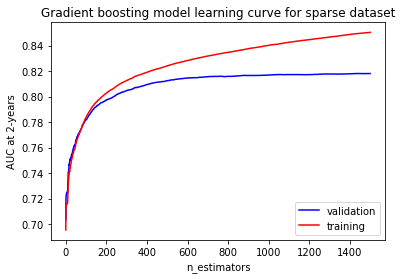

In [51]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

x = range(len(gbm2_staged_auc))
plt.plot(x, gbm2_staged_auc, color = 'blue', label = 'validation')
plt.plot(x, gbm2_staged_auc_tr, color = 'red', label = 'training')
plt.legend(loc = 'lower right')

plt.xlabel("n_estimators")
plt.ylabel("AUC at 2-years")
plt.title('Gradient boosting model learning curve for sparse dataset')

plt.show()

In [52]:
# Average AUC for every 25 additional trees. 
mean2_auc_list = []
for x in np.arange(0, len(gbm2_staged_auc), 25):
    mean2_auc_list.append(np.mean(gbm2_staged_auc[x:x+24]))

In [53]:
print('Number of trees where 2 year AUC on validation dataset beings to downgrade:', np.where(np.diff(mean2_auc_list) < 0)[0][0]*25)
print('Validation dataset AUC before degrading:', gbm2_staged_auc[np.where(np.diff(mean2_auc_list) < 0)[0][0]*25])
print('Training dataset AUC before degrading:', gbm2_staged_auc_tr[np.where(np.diff(mean2_auc_list) < 0)[0][0]*25])

Number of trees where 2 year AUC on validation dataset beings to downgrade: 750
Validation dataset AUC before degrading: 0.8158305405591528
Training dataset AUC before degrading: 0.8333348624729833


**Performance of the sparse model appears about equivalent to the full model in regards to discriminatory performance on the validation set. The advantages of using the sparse model include less risk of overfitting of training set, faster computational speed, and improved interpretability of feature importance. In addition, there might be improved imputations of missing values with MICE. For these reasons, we'll plan to proceed with the sparse model.**

### 2.3 Further tuning of tree hyperparameters

**Tree depth and subsample will be tuned using a halving grid search with 3-fold cross validation. The other main tree hyperparameter is the minimum sample size in a terminal node (ie., leaf), but since we're using short trees it's unlikely to have significant impact on performance and so we'll omit from the parameter search to save computing time.** 

**Performing a traditional cartesian grid search for gradient boosting model tree hyperparameters is computationally challengng. A halving grid search approach is selected instead since it is much faster. The major drawback of the halving grid search is that good configurations that are slow to converge at the beginning will be pruned prematurely so you can’t be entirely ensure that you’ve identified the best hyperparameters.**  

In [54]:
train_x_red = train_x.drop(columns = drop_labs)

In [55]:
train_x_red.loc[:, 'alp_max_na'] = np.where(train_x_red['alp_max'].isna(), 1, 0)
train_x_red.loc[:, 'alt_max_na'] = np.where(train_x_red['alt_max'].isna(), 1, 0)
train_x_red.loc[:, 'ast_max_na'] = np.where(train_x_red['ast_max'].isna(), 1, 0)
train_x_red.loc[:, 'calcium_max_na'] = np.where(train_x_red['calcium_max'].isna(), 1, 0)
train_x_red.loc[:, 'creatinine_max_na'] = np.where(train_x_red['creatinine_max'].isna(), 1, 0)
train_x_red.loc[:, 'total_bilirubin_max_na'] = np.where(train_x_red['total_bilirubin_max'].isna(), 1, 0)
train_x_red.loc[:, 'wbc_max_na'] = np.where(train_x_red['wbc_max'].isna(), 1, 0)
train_x_red.loc[:, 'albumin_min_na'] = np.where(train_x_red['albumin_min'].isna(), 1, 0)
train_x_red.loc[:, 'bicarb_min_na'] = np.where(train_x_red['bicarb_min'].isna(), 1, 0)
train_x_red.loc[:, 'hemoglobin_min_na'] = np.where(train_x_red['hemoglobin_min'].isna(), 1, 0)
train_x_red.loc[:, 'platelet_min_na'] = np.where(train_x_red['platelet_min'].isna(), 1, 0)
train_x_red.loc[:, 'sodium_min_na'] = np.where(train_x_red['sodium_min'].isna(), 1, 0)
train_x_red.loc[:, 'wbc_min_na'] = np.where(train_x_red['wbc_min'].isna(), 1, 0)

In [56]:
train_x_red.shape

(25341, 144)

In [57]:
# Find all pipe item unique keys 
pipe = make_pipeline(preprocessor_red, GradientBoostingSurvivalAnalysis(n_estimators = 750,
                                                                        learning_rate = 0.05,
                                                                        random_state = 42))

estimator = as_cumulative_dynamic_auc_scorer(pipe, times = [730])

sorted(estimator.get_params().keys())

['estimator',
 'estimator__columntransformer',
 'estimator__columntransformer__cat',
 'estimator__columntransformer__cat__categories',
 'estimator__columntransformer__cat__drop',
 'estimator__columntransformer__cat__dtype',
 'estimator__columntransformer__cat__handle_unknown',
 'estimator__columntransformer__cat__sparse',
 'estimator__columntransformer__n_jobs',
 'estimator__columntransformer__num',
 'estimator__columntransformer__num__imputer',
 'estimator__columntransformer__num__imputer__add_indicator',
 'estimator__columntransformer__num__imputer__copy',
 'estimator__columntransformer__num__imputer__fill_value',
 'estimator__columntransformer__num__imputer__missing_values',
 'estimator__columntransformer__num__imputer__strategy',
 'estimator__columntransformer__num__imputer__verbose',
 'estimator__columntransformer__num__memory',
 'estimator__columntransformer__num__std_scaler',
 'estimator__columntransformer__num__std_scaler__copy',
 'estimator__columntransformer__num__std_scaler_

In [58]:
pipe = make_pipeline(preprocessor_red, GradientBoostingSurvivalAnalysis(n_estimators = 750,
                                                                        learning_rate = 0.05,
                                                                        random_state = 42))

# 3 fold cross-validation
cv = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)

# Parameter gird 
param_grid = {'estimator__gradientboostingsurvivalanalysis__max_depth': [2, 3, 4], 
              'estimator__gradientboostingsurvivalanalysis__subsample': [0.5, 0.75, 0.9]}

gbm_search = HalvingGridSearchCV(
    as_cumulative_dynamic_auc_scorer(pipe, 730),
    param_grid,
    cv = cv,
    factor = 2,
    resource = 'n_samples',
    refit = False,
    verbose = 1,
    random_state = 42,
    n_jobs = -1)

# Run search 
warnings.filterwarnings('ignore')
gbm_search.fit(train_x_red, train_y)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 3167
max_resources_: 25341
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 9
n_resources: 3167
Fitting 3 folds for each of 9 candidates, totalling 27 fits
----------
iter: 1
n_candidates: 5
n_resources: 6334
Fitting 3 folds for each of 5 candidates, totalling 15 fits
----------
iter: 2
n_candidates: 3
n_resources: 12668
Fitting 3 folds for each of 3 candidates, totalling 9 fits
----------
iter: 3
n_candidates: 2
n_resources: 25336
Fitting 3 folds for each of 2 candidates, totalling 6 fits


HalvingGridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                    estimator=as_cumulative_dynamic_auc_scorer(estimator=Pipeline(steps=[('columntransformer',
                                                                                          ColumnTransformer(remainder='passthrough',
                                                                                                            transformers=[('num',
                                                                                                                           Pipeline(steps=[('imputer',
                                                                                                                                            SimpleImputer(strategy='median')),
                                                                                                                                           ('std_scaler',
                                                               

In [59]:
gbm_search.best_params_

{'estimator__gradientboostingsurvivalanalysis__max_depth': 4,
 'estimator__gradientboostingsurvivalanalysis__subsample': 0.75}

In [60]:
gbm_search_results = pd.DataFrame(gbm_search.cv_results_)

In [61]:
gbm_search_results.sort_values(by = 'rank_test_score').head(10)

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__gradientboostingsurvivalanalysis__max_depth,param_estimator__gradientboostingsurvivalanalysis__subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
18,3,25336,3615.026322,1.730507,0.155675,0.015917,4,0.75,{'estimator__gradientboostingsurvivalanalysis_...,0.804743,0.814324,0.816233,0.811767,0.005028,1,0.864438,0.857954,0.857896,0.860096,0.003071
17,3,25336,3809.170807,4.753662,0.159481,0.009703,4,0.9,{'estimator__gradientboostingsurvivalanalysis_...,0.803017,0.813613,0.815942,0.810857,0.005625,2,0.863959,0.857115,0.857239,0.859438,0.003198
15,2,12668,1224.411004,1.755241,0.107004,0.027373,4,0.75,{'estimator__gradientboostingsurvivalanalysis_...,0.803777,0.808361,0.808076,0.806738,0.002097,3,0.881943,0.883404,0.879770,0.881706,0.001493
16,2,12668,1096.655806,252.287144,0.074285,0.004709,4,0.9,{'estimator__gradientboostingsurvivalanalysis_...,0.802242,0.809216,0.806494,0.805984,0.002870,4,0.882990,0.883349,0.879706,0.882015,0.001639
14,2,12668,1224.815689,2.777620,0.117482,0.028694,4,0.5,{'estimator__gradientboostingsurvivalanalysis_...,0.800796,0.809185,0.806089,0.805357,0.003464,5,0.879258,0.882752,0.878126,0.880046,0.001969
9,1,6334,304.001640,1.739653,0.069502,0.020763,4,0.9,{'estimator__gradientboostingsurvivalanalysis_...,0.803697,0.806457,0.780649,0.796934,0.011570,6,0.907748,0.911726,0.911089,0.910188,0.001745
11,1,6334,265.630545,17.077100,0.059536,0.024784,4,0.75,{'estimator__gradientboostingsurvivalanalysis_...,0.803372,0.804444,0.781272,0.796363,0.010679,7,0.904691,0.911623,0.909949,0.908754,0.002954
13,1,6334,226.389561,4.450702,0.046763,0.009232,4,0.5,{'estimator__gradientboostingsurvivalanalysis_...,0.801561,0.806447,0.780976,0.796328,0.011037,8,0.902731,0.910398,0.907780,0.906970,0.003182
10,1,6334,266.130475,0.674444,0.072187,0.005408,3,0.5,{'estimator__gradientboostingsurvivalanalysis_...,0.802260,0.803412,0.783042,0.796238,0.009343,9,0.867653,0.875878,0.870545,0.871359,0.003407
12,1,6334,235.467039,1.685689,0.048020,0.005707,3,0.75,{'estimator__gradientboostingsurvivalanalysis_...,0.802603,0.801822,0.783513,0.795979,0.008821,10,0.871191,0.877018,0.871195,0.873135,0.002746


### 2.4 Building and evaluating final model 

In [62]:
test_x_red = test_x.drop(columns = drop_labs)

In [63]:
test_x_red.loc[:, 'alp_max_na'] = np.where(test_x_red['alp_max'].isna(), 1, 0)
test_x_red.loc[:, 'alt_max_na'] = np.where(test_x_red['alt_max'].isna(), 1, 0)
test_x_red.loc[:, 'ast_max_na'] = np.where(test_x_red['ast_max'].isna(), 1, 0)
test_x_red.loc[:, 'calcium_max_na'] = np.where(test_x_red['calcium_max'].isna(), 1, 0)
test_x_red.loc[:, 'creatinine_max_na'] = np.where(test_x_red['creatinine_max'].isna(), 1, 0)
test_x_red.loc[:, 'total_bilirubin_max_na'] = np.where(test_x_red['total_bilirubin_max'].isna(), 1, 0)
test_x_red.loc[:, 'wbc_max_na'] = np.where(test_x_red['wbc_max'].isna(), 1, 0)
test_x_red.loc[:, 'albumin_min_na'] = np.where(test_x_red['albumin_min'].isna(), 1, 0)
test_x_red.loc[:, 'bicarb_min_na'] = np.where(test_x_red['bicarb_min'].isna(), 1, 0)
test_x_red.loc[:, 'hemoglobin_min_na'] = np.where(test_x_red['hemoglobin_min'].isna(), 1, 0)
test_x_red.loc[:, 'platelet_min_na'] = np.where(test_x_red['platelet_min'].isna(), 1, 0)
test_x_red.loc[:, 'sodium_min_na'] = np.where(test_x_red['sodium_min'].isna(), 1, 0)
test_x_red.loc[:, 'wbc_min_na'] = np.where(test_x_red['wbc_min'].isna(), 1, 0)

In [64]:
test_x_red.shape

(6336, 144)

In [65]:
gbm_crude = make_pipeline(preprocessor_red, GradientBoostingSurvivalAnalysis(n_estimators = 750,
                                                                             learning_rate = 0.05,
                                                                             max_depth = 4,
                                                                             subsample = 0.75,
                                                                             verbose = 1,
                                                                             random_state = 42))

gbm_crude.fit(train_x_red, train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       98534.3623          22.6008          122.06m
         2       98500.3907          21.2528          117.29m
         3       98926.1922          19.3427          116.73m
         4       98506.3317          19.8272          119.68m
         5       98342.2404          17.8932          123.10m
         6       98005.7948          18.2657          124.02m
         7       98256.7045          17.8314          124.99m
         8       98325.0529          15.7795          123.27m
         9       98146.5432          15.0109          121.74m
        10       98343.3125          14.7137          120.78m
        20       97909.7280          10.7290          116.78m
        30       97272.5338           8.6987          117.32m
        40       96995.5430           6.9658          118.16m
        50       97005.5337           5.7235          117.80m
        60       96596.8900           4.8651          116.90m
       

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'delta_met_diagnosis',
                                                   'weight_diag', 'bmi_diag',
                                                   'weight_pct_change',
                                                   'weight_slope',
                                                   'albumin_diag', 'alp_diag',
                                                   'alt_diag', 'ast_diag',
                                            

In [66]:
gbm_risk_scores_te = gbm_crude.predict(test_x_red)
gbm_auc_te = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, 730)[0][0]
print('Test set AUC at 2 years:', gbm_auc_te)

Test set AUC at 2 years: 0.8177073200968971


In [67]:
gbm_risk_scores_tr = gbm_crude.predict(train_x_red)
gbm_auc_tr = cumulative_dynamic_auc(train_y, train_y, gbm_risk_scores_tr, 730)[0][0]
print('Training set AUC at 2 years:', gbm_auc_tr)

Training set AUC at 2 years: 0.8494098390943354


In [68]:
# Bootstrap 10000 2 yr AUCs for test set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_te = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_te), len(gbm_risk_scores_te))
    auc_yr = cumulative_dynamic_auc(train_y, test_y[indices], gbm_risk_scores_te[indices], 730)[0][0]
    bootstrapped_scores_te.append(auc_yr)

In [69]:
# Standard error of mean for test set AUC
sorted_scores_te = np.array(bootstrapped_scores_te)
sorted_scores_te.sort()

conf_lower_te = sorted_scores_te[int(0.025 * len(sorted_scores_te))]
conf_upper_te = sorted_scores_te[int(0.975 * len(sorted_scores_te))]

standard_error_te = (conf_upper_te - conf_lower_te) / 3.92
print('Test set AUC standard error:', standard_error_te)

Test set AUC standard error: 0.005979492426280793


In [70]:
# Bootstrap 10000 2-yr AUCs for train set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_tr = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_tr), len(gbm_risk_scores_tr))
    auc_yr = cumulative_dynamic_auc(train_y, train_y[indices], gbm_risk_scores_tr[indices], 730)[0][0]
    bootstrapped_scores_tr.append(auc_yr)

In [71]:
# Standard error of mean for train set AUC
sorted_scores_tr = np.array(bootstrapped_scores_tr)
sorted_scores_tr.sort()

conf_lower_tr = sorted_scores_tr[int(0.025 * len(sorted_scores_tr))]
conf_upper_tr = sorted_scores_tr[int(0.975 * len(sorted_scores_tr))]

standard_error_tr = (conf_upper_tr - conf_lower_tr) / 3.92
print('Training set AUC standard error', standard_error_tr)

Training set AUC standard error 0.0027890477538223338


In [72]:
crude_auc_data = {'model': ['gbm_crude'],
                  'auc_2yr_te': [gbm_auc_te],
                  'sem_te': [standard_error_te],
                  'auc_2yr_tr': [gbm_auc_tr],
                  'sem_tr': [standard_error_tr]}

crude_auc_df = pd.DataFrame(crude_auc_data)

In [73]:
crude_auc_df

,model,auc_2yr_te,sem_te,auc_2yr_tr,sem_tr
0,gbm_crude,0.817707,0.005979,0.84941,0.002789


In [74]:
crude_auc_df.to_csv('crude_auc_df.csv', index = False, header = True)

In [75]:
times = np.arange(30, 1810, 30)
crude_gbm_auc_over5 = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, times)[0]

times_data = {}
values = crude_gbm_auc_over5
time_names = []

for x in range(len(times)):
    time_names.append('time_'+str(times[x]))

for i in range(len(time_names)):
    times_data[time_names[i]] = values[i]
    
crude_auc_over5 = pd.DataFrame(times_data, index = ['gbm_crude'])

In [76]:
crude_auc_over5

,time_30,time_60,time_90,time_120,time_150,time_180,time_210,time_240,time_270,time_300,...,time_1530,time_1560,time_1590,time_1620,time_1650,time_1680,time_1710,time_1740,time_1770,time_1800
gbm_crude,0.865653,0.88424,0.866949,0.865569,0.861561,0.852376,0.85285,0.850731,0.851161,0.849431,...,0.782725,0.779661,0.781463,0.781015,0.77931,0.779304,0.777667,0.776433,0.776933,0.776247


In [77]:
crude_auc_over5.to_csv('crude_auc_over5.csv', index = True, header = True)

In [78]:
# Variables passing through pipeline
cat_encoder = list(preprocessor_red.transformers_[1][1].get_feature_names(categorical_features))
pass_through = list(train_x_red.iloc[:, preprocessor_red.transformers_[2][2]].columns)
attributes_gbm = numerical_features_red + cat_encoder + pass_through

Total number of features: 195
Number of non-zero features in final model: 190


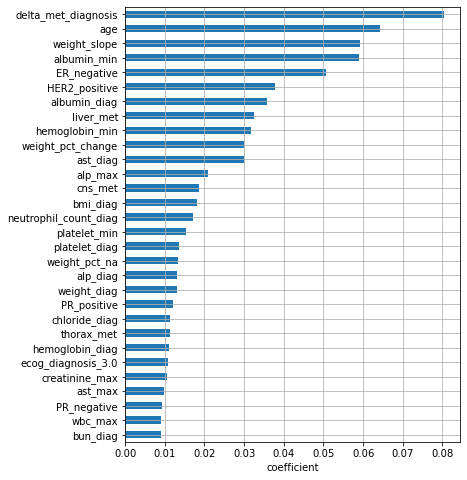

In [79]:
# Dataframe of coefficients for each variable 
coefficients_gbm = pd.DataFrame(
    gbm_crude.named_steps['gradientboostingsurvivalanalysis'].feature_importances_,
    index = attributes_gbm,
    columns = ['coefficient']
)

print('Total number of features: {}'.format(len(attributes_gbm)))

non_zero = np.sum(coefficients_gbm.iloc[:, 0] != 0)
print('Number of non-zero features in final model: {}'.format(non_zero))

non_zero_coefs = coefficients_gbm.query('coefficient != 0')
coef_order = non_zero_coefs.abs().sort_values('coefficient').tail(30).index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax = ax, legend = False)
ax.set_xlabel('coefficient')
ax.grid(True)

## 3 Random survival forest model

In [80]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import StratifiedKFold, HalvingRandomSearchCV
from sklearn.pipeline import make_pipeline

from sksurv.metrics import cumulative_dynamic_auc, as_cumulative_dynamic_auc_scorer

from sksurv.ensemble import RandomSurvivalForest

from joblib import dump, load 

import warnings 

**Similar to the gradient boosting survival model, the random survival model will first be configured by determining ideal number of trees using early stopping. Unlike the gradient boosting survival model, performance of the test set should not decrease with additional trees, so the main consideration is ensuring sufficiently high number of trees to achieve optimal test performance while minimzing computational time (ie., not building unnecessary number of trees). Once the ideal tree number is identified, a halving grid search with 3-fold cross validation will be performed to tune hyperparameters, though random forest models typically have excellent out-of-the-box performance so tuning will be cursory.**  

### 3.1 Number of trees 

In [81]:
# Create function that adds tree one at a time, calculates AUC at 1-yr on validation set, 
# and breaks once validation AUC decreases 5 times in a row

rsf = RandomSurvivalForest(min_samples_leaf = 10,
                           max_features = 0.333,
                           warm_start = True,
                           verbose = 0,
                           random_state = 42)

sub_train_xt_red = preprocessor_red.fit_transform(sub_train_x_red)
val_xt_red = preprocessor_red.transform(val_x_red)

max_yr_auc = 0
error_going_up = 0

for n_estimators in range(1, 1000): 
    rsf.n_estimators = n_estimators
    rsf.fit(sub_train_xt_red, sub_train_y)
    
    rsf_chf_funcs = rsf.predict_cumulative_hazard_function(val_xt_red)
    rsf_risk_scores = np.row_stack([chf(730) for chf in rsf_chf_funcs])
    rsf_yr_auc = cumulative_dynamic_auc(sub_train_y, val_y, rsf_risk_scores, 730)[0][0]
    
    if rsf_yr_auc > max_yr_auc:
        max_yr_auc = rsf_yr_auc
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break

In [82]:
rsf_chf_funcs = rsf.predict_cumulative_hazard_function(val_xt_red)
rsf_risk_scores = np.row_stack([chf(730) for chf in rsf_chf_funcs])
rsf_yr_auc = cumulative_dynamic_auc(sub_train_y, val_y, rsf_risk_scores, 730)[0][0]

print('Ideal number of trees:', rsf.n_estimators)
print('Validation set AUC at 2 years with ideal tree number:', round(rsf_yr_auc, 5))

Ideal number of trees: 39
Validation set AUC at 2 years with ideal tree number: 0.79071


### 3.2 Hyperparameter tuning 

**Fifty trees will likely be enough to ensure optimal AUC performance. Next, we'll perform a grid search to tune hyperparameters. The hyperparamter with the largest impact on performance other than tree number is the number of features considered at any given split (ie., max_features). (Side note: if the number of features considered at each split includes all features (ie., max_features = 1) then the algrorithm will be equivalent to bagging decision trees.) Tree complexity, specifically number of samples in leaf nodes, will also be tuned in the grid search, though its impact on performance is likely marginal in comparison to number of trees or number of features considered at each split.** 

In [83]:
# Find all pipe item unique keys 
pipe = make_pipeline(preprocessor_red, RandomSurvivalForest(n_estimators = 50,
                                                            verbose = 0,
                                                            random_state = 42))

estimator = as_cumulative_dynamic_auc_scorer(pipe, times = [730])

sorted(estimator.get_params().keys())

['estimator',
 'estimator__columntransformer',
 'estimator__columntransformer__cat',
 'estimator__columntransformer__cat__categories',
 'estimator__columntransformer__cat__drop',
 'estimator__columntransformer__cat__dtype',
 'estimator__columntransformer__cat__handle_unknown',
 'estimator__columntransformer__cat__sparse',
 'estimator__columntransformer__n_jobs',
 'estimator__columntransformer__num',
 'estimator__columntransformer__num__imputer',
 'estimator__columntransformer__num__imputer__add_indicator',
 'estimator__columntransformer__num__imputer__copy',
 'estimator__columntransformer__num__imputer__fill_value',
 'estimator__columntransformer__num__imputer__missing_values',
 'estimator__columntransformer__num__imputer__strategy',
 'estimator__columntransformer__num__imputer__verbose',
 'estimator__columntransformer__num__memory',
 'estimator__columntransformer__num__std_scaler',
 'estimator__columntransformer__num__std_scaler__copy',
 'estimator__columntransformer__num__std_scaler_

In [84]:
pipe = make_pipeline(preprocessor_red, RandomSurvivalForest(n_estimators = 50,
                                                            verbose = 0,
                                                            random_state = 42))

# 3 fold cross-validation
cv = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)

# Parameter gird 
param_grid = {'estimator__randomsurvivalforest__max_features': [0.01, 0.05, 0.1, 0.333], 
              'estimator__randomsurvivalforest__min_samples_leaf': [5, 10, 15]}

rsf_search = HalvingRandomSearchCV(
    as_cumulative_dynamic_auc_scorer(pipe, 730),
    param_distributions = param_grid,
    cv = cv,
    factor = 3,
    resource = 'n_samples',
    min_resources = 2500,
    refit = False,
    verbose = 1,
    random_state = 42,
    n_jobs = -1)

# Run search 
warnings.filterwarnings('ignore')
rsf_search.fit(train_x_red, train_y)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 2500
max_resources_: 25341
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 10
n_resources: 2500
Fitting 3 folds for each of 10 candidates, totalling 30 fits
----------
iter: 1
n_candidates: 4
n_resources: 7500
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 2
n_candidates: 2
n_resources: 22500
Fitting 3 folds for each of 2 candidates, totalling 6 fits


HalvingRandomSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                      estimator=as_cumulative_dynamic_auc_scorer(estimator=Pipeline(steps=[('columntransformer',
                                                                                            ColumnTransformer(remainder='passthrough',
                                                                                                              transformers=[('num',
                                                                                                                             Pipeline(steps=[('imputer',
                                                                                                                                              SimpleImputer(strategy='median')),
                                                                                                                                             ('std_scaler',
                                                 

In [85]:
rsf_search.best_params_

{'estimator__randomsurvivalforest__min_samples_leaf': 10,
 'estimator__randomsurvivalforest__max_features': 0.333}

In [86]:
rsf_search_results = pd.DataFrame(rsf_search.cv_results_)

In [87]:
rsf_search_results.sort_values(by = 'rank_test_score').head(10)

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__randomsurvivalforest__min_samples_leaf,param_estimator__randomsurvivalforest__max_features,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
14,2,22500,1329.249230,20.281179,6.801291,0.535094,10,0.333,{'estimator__randomsurvivalforest__min_samples...,0.788833,0.788613,0.784460,0.787302,0.002012,1,0.905246,0.902261,0.899808,0.902438,0.002224
15,2,22500,1845.729831,50.307809,6.399223,0.876628,5,0.333,{'estimator__randomsurvivalforest__min_samples...,0.787979,0.789559,0.784057,0.787198,0.002313,2,0.943263,0.939504,0.939331,0.940699,0.001814
12,1,7500,380.596397,75.363405,0.698645,0.262590,5,0.333,{'estimator__randomsurvivalforest__min_samples...,0.776923,0.777472,0.764930,0.773108,0.005788,3,0.942027,0.942488,0.942380,0.942298,0.000197
10,1,7500,369.588138,11.387661,0.733242,0.139430,10,0.333,{'estimator__randomsurvivalforest__min_samples...,0.779009,0.772949,0.766991,0.772983,0.004906,4,0.900964,0.900307,0.900870,0.900714,0.000290
11,1,7500,336.265016,11.529560,0.607661,0.114647,15,0.333,{'estimator__randomsurvivalforest__min_samples...,0.780065,0.773982,0.764676,0.772908,0.006329,5,0.872273,0.874141,0.870902,0.872438,0.001327
13,1,7500,83.137862,3.904782,0.388084,0.013414,10,0.1,{'estimator__randomsurvivalforest__min_samples...,0.778806,0.772869,0.762436,0.771370,0.006766,6,0.885692,0.883168,0.883559,0.884140,0.001109
9,0,2500,11.913158,2.136422,0.072169,0.017523,10,0.1,{'estimator__randomsurvivalforest__min_samples...,0.782523,0.745077,0.763831,0.763810,0.015287,7,0.876896,0.883580,0.889802,0.883426,0.005270
1,0,2500,73.607443,2.251551,0.247009,0.077857,5,0.333,{'estimator__randomsurvivalforest__min_samples...,0.777285,0.746701,0.765332,0.763106,0.012585,8,0.942247,0.942180,0.946137,0.943521,0.001850
7,0,2500,39.848509,4.596830,0.086718,0.017441,15,0.333,{'estimator__randomsurvivalforest__min_samples...,0.770805,0.745082,0.766792,0.760893,0.011299,9,0.865916,0.868675,0.874930,0.869840,0.003771
0,0,2500,51.740884,1.156365,0.177897,0.025526,10,0.333,{'estimator__randomsurvivalforest__min_samples...,0.774447,0.745614,0.762433,0.760831,0.011825,10,0.896725,0.897317,0.903427,0.899156,0.003030


### 3.3 Building model and assessing performance

In [88]:
rsf = make_pipeline(preprocessor_red, RandomSurvivalForest(n_estimators = 50,
                                                           max_features = 0.333, 
                                                           min_samples_leaf = 10,
                                                           n_jobs = -1,
                                                           verbose = 0,
                                                           random_state = 42))

rsf.fit(train_x_red, train_y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'delta_met_diagnosis',
                                                   'weight_diag', 'bmi_diag',
                                                   'weight_pct_change',
                                                   'weight_slope',
                                                   'albumin_diag', 'alp_diag',
                                                   'alt_diag', 'ast_diag',
                                            

In [89]:
rsf_chf_funcs_te = rsf.predict_cumulative_hazard_function(test_x_red)
rsf_risk_scores_te = np.row_stack([chf(730) for chf in rsf_chf_funcs_te])
rsf_auc_te = cumulative_dynamic_auc(train_y, test_y, rsf_risk_scores_te, 730)[0][0]
print('Test set AUC at 2 years:', rsf_auc_te)

Test set AUC at 2 years: 0.7976195556270368


In [90]:
rsf_chf_funcs_tr = rsf.predict_cumulative_hazard_function(train_x_red)
rsf_risk_scores_tr = np.row_stack([chf(730) for chf in rsf_chf_funcs_tr])
rsf_auc_tr = cumulative_dynamic_auc(train_y, train_y, rsf_risk_scores_tr, 730)[0][0]
print('Training set AUC at 2 years:', rsf_auc_tr)

Training set AUC at 2 years: 0.9168182206898802


In [91]:
# Bootstrap 10000 2 yr AUCs for test set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_te = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(rsf_risk_scores_te), len(rsf_risk_scores_te))
    auc_yr = cumulative_dynamic_auc(train_y, test_y[indices], rsf_risk_scores_te[indices], 730)[0][0]
    bootstrapped_scores_te.append(auc_yr)

In [92]:
# Standard error of mean for test set AUC
sorted_scores_te = np.array(bootstrapped_scores_te)
sorted_scores_te.sort()

conf_lower_te = sorted_scores_te[int(0.025 * len(sorted_scores_te))]
conf_upper_te = sorted_scores_te[int(0.975 * len(sorted_scores_te))]

standard_error_te = (conf_upper_te - conf_lower_te) / 3.92
print('Test set AUC standard error:', standard_error_te)

Test set AUC standard error: 0.006318124375527251


In [93]:
# Bootstrap 10000 2-yr AUCs for train set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_tr = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(rsf_risk_scores_tr), len(rsf_risk_scores_tr))
    auc_yr = cumulative_dynamic_auc(train_y, train_y[indices], rsf_risk_scores_tr[indices], 730)[0][0]
    bootstrapped_scores_tr.append(auc_yr)

In [94]:
# Standard error of mean for train set AUC
sorted_scores_tr = np.array(bootstrapped_scores_tr)
sorted_scores_tr.sort()

conf_lower_tr = sorted_scores_tr[int(0.025 * len(sorted_scores_tr))]
conf_upper_tr = sorted_scores_tr[int(0.975 * len(sorted_scores_tr))]

standard_error_tr = (conf_upper_tr - conf_lower_tr) / 3.92
print('Training set AUC standard error', standard_error_tr)

Training set AUC standard error 0.0019403664278070229


In [95]:
crude_auc_data = {'model': 'rsf_crude',
                  'auc_2yr_te': rsf_auc_te,
                  'sem_te': standard_error_te,
                  'auc_2yr_tr': rsf_auc_tr,
                  'sem_tr': standard_error_tr}

In [96]:
crude_auc_df = pd.read_csv('crude_auc_df.csv')

In [97]:
crude_auc_df = crude_auc_df.append(crude_auc_data, ignore_index = True)

In [98]:
crude_auc_df

,model,auc_2yr_te,sem_te,auc_2yr_tr,sem_tr
0,gbm_crude,0.817707,0.005979,0.849410,0.002789
1,rsf_crude,0.797620,0.006318,0.916818,0.001940


In [99]:
crude_auc_df.to_csv('crude_auc_df.csv', index = False, header = True)

In [100]:
times = np.arange(30, 1810, 30)

rsf_chf_funcs_te = rsf.predict_cumulative_hazard_function(test_x_red)
rsf_risk_scores_te = np.row_stack([chf(times) for chf in rsf_chf_funcs_te])
crude_rsf_auc_over5 = cumulative_dynamic_auc(train_y, test_y, rsf_risk_scores_te, times)[0]

times_data = {}
values = crude_rsf_auc_over5
time_names = []

for x in range(len(times)):
    time_names.append('time_'+str(times[x]))

for i in range(len(time_names)):
    times_data[time_names[i]] = values[i]
    
crude_rsf_over5_df = pd.DataFrame(times_data, index = ['rsf_crude'])

In [101]:
crude_auc_over5 = pd.read_csv('crude_auc_over5.csv', index_col = 0)

In [102]:
crude_auc_over5 = crude_auc_over5.append(crude_rsf_over5_df, ignore_index = False)

In [103]:
crude_auc_over5

,time_30,time_60,time_90,time_120,time_150,time_180,time_210,time_240,time_270,time_300,...,time_1530,time_1560,time_1590,time_1620,time_1650,time_1680,time_1710,time_1740,time_1770,time_1800
gbm_crude,0.865653,0.884240,0.866949,0.865569,0.861561,0.852376,0.852850,0.850731,0.851161,0.849431,...,0.782725,0.779661,0.781463,0.781015,0.77931,0.779304,0.777667,0.776433,0.776933,0.776247
rsf_crude,0.866668,0.876143,0.852497,0.850469,0.846343,0.836480,0.835673,0.831395,0.830522,0.829236,...,0.763159,0.759102,0.761464,0.761499,0.75796,0.756729,0.756293,0.756140,0.755578,0.754173


In [104]:
crude_auc_over5.to_csv('crude_auc_over5.csv', index = True, header = True)

**No feature importance attribute is available at this time for the random survival forest model.**

**The gradient boosted survival model outperforms the random survival forest in regards to test set 2 year AUC.**

## 4. Penalized Cox models 

**The next group of models we'll build is the penalized Cox variety which includes ridge, LASSO, and elastic net. The main challenge will be selecting the strength of the alpha penalty for each model. The penalty will be determined by performing a grid search with cross-validation.**

In [105]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer

from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.metrics import cumulative_dynamic_auc, as_cumulative_dynamic_auc_scorer

import warnings 

import matplotlib.pyplot as plt

### 4.1 Ridge

In [106]:
# Find all pipe item unique keys 
pipe = make_pipeline(preprocessor_red, CoxPHSurvivalAnalysis())

estimator = as_cumulative_dynamic_auc_scorer(pipe, times = [730])

sorted(estimator.get_params().keys())

['estimator',
 'estimator__columntransformer',
 'estimator__columntransformer__cat',
 'estimator__columntransformer__cat__categories',
 'estimator__columntransformer__cat__drop',
 'estimator__columntransformer__cat__dtype',
 'estimator__columntransformer__cat__handle_unknown',
 'estimator__columntransformer__cat__sparse',
 'estimator__columntransformer__n_jobs',
 'estimator__columntransformer__num',
 'estimator__columntransformer__num__imputer',
 'estimator__columntransformer__num__imputer__add_indicator',
 'estimator__columntransformer__num__imputer__copy',
 'estimator__columntransformer__num__imputer__fill_value',
 'estimator__columntransformer__num__imputer__missing_values',
 'estimator__columntransformer__num__imputer__strategy',
 'estimator__columntransformer__num__imputer__verbose',
 'estimator__columntransformer__num__memory',
 'estimator__columntransformer__num__std_scaler',
 'estimator__columntransformer__num__std_scaler__copy',
 'estimator__columntransformer__num__std_scaler_

In [107]:
pipe = make_pipeline(preprocessor_red, CoxPHSurvivalAnalysis())

# 5 fold cross-validation
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

# Parameter gird 
param_grid = {'estimator__coxphsurvivalanalysis__alpha': 10. ** np.linspace(-4, 4, 25)}

ridge_search = GridSearchCV(
    as_cumulative_dynamic_auc_scorer(pipe, 730),
    param_grid = param_grid,
    cv = cv,
    n_jobs = -1,
    refit = False)

# Run search 
warnings.filterwarnings('ignore')
ridge_search.fit(train_x_red, train_y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=as_cumulative_dynamic_auc_scorer(estimator=Pipeline(steps=[('columntransformer',
                                                                                   ColumnTransformer(remainder='passthrough',
                                                                                                     transformers=[('num',
                                                                                                                    Pipeline(steps=[('imputer',
                                                                                                                                     SimpleImputer(strategy='median')),
                                                                                                                                    ('std_scaler',
                                                                                                                

In [108]:
ridge_search.best_params_

{'estimator__coxphsurvivalanalysis__alpha': 215.44346900318823}

In [109]:
best_ridge_alpha = ridge_search.best_params_.get('estimator__coxphsurvivalanalysis__alpha')

In [110]:
ridge_search_results = pd.DataFrame(ridge_search.cv_results_)

In [111]:
ridge_search_results.sort_values(by = 'rank_test_score').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__coxphsurvivalanalysis__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
19,34.596651,1.729968,0.086900,0.010572,215.443469,{'estimator__coxphsurvivalanalysis__alpha': 21...,0.779565,0.784431,0.788480,0.785391,0.792247,0.786023,0.004229,1
18,33.412610,3.010102,0.089291,0.007671,100.0,{'estimator__coxphsurvivalanalysis__alpha': 10...,0.778636,0.784396,0.787213,0.786429,0.793071,0.785949,0.004657,2
17,33.382580,1.620059,0.085060,0.009901,46.415888,{'estimator__coxphsurvivalanalysis__alpha': 46...,0.777852,0.784300,0.786026,0.786954,0.793487,0.785724,0.005017,3
16,34.032858,1.961229,0.084296,0.007754,21.544347,{'estimator__coxphsurvivalanalysis__alpha': 21...,0.777211,0.784368,0.785062,0.787324,0.793730,0.785539,0.005315,4
15,34.329449,1.810749,0.099959,0.028239,10.0,{'estimator__coxphsurvivalanalysis__alpha': 10.0},0.776768,0.784450,0.784463,0.787458,0.793861,0.785400,0.005516,5
14,34.148437,1.804196,0.090287,0.012977,4.641589,{'estimator__coxphsurvivalanalysis__alpha': 4....,0.776440,0.784549,0.784083,0.787617,0.793815,0.785301,0.005629,6
13,34.899035,1.743613,0.080704,0.005833,2.154435,{'estimator__coxphsurvivalanalysis__alpha': 2....,0.776228,0.784545,0.783855,0.787660,0.793796,0.785217,0.005704,7
20,32.540601,3.843086,0.078861,0.009745,464.158883,{'estimator__coxphsurvivalanalysis__alpha': 46...,0.779988,0.783343,0.788957,0.783257,0.790439,0.785197,0.003897,8
12,35.531446,2.846189,0.093156,0.021397,1.0,{'estimator__coxphsurvivalanalysis__alpha': 1.0},0.776080,0.784538,0.783722,0.787642,0.793721,0.785141,0.005733,9
11,35.595194,2.635440,0.087197,0.006958,0.464159,{'estimator__coxphsurvivalanalysis__alpha': 0....,0.775985,0.784544,0.783675,0.787648,0.793710,0.785112,0.005763,10


In [112]:
ridge = make_pipeline(preprocessor_red, CoxPHSurvivalAnalysis(alpha = best_ridge_alpha))

ridge.fit(train_x_red, train_y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'delta_met_diagnosis',
                                                   'weight_diag', 'bmi_diag',
                                                   'weight_pct_change',
                                                   'weight_slope',
                                                   'albumin_diag', 'alp_diag',
                                                   'alt_diag', 'ast_diag',
                                            

In [113]:
ridge_risk_scores_te = ridge.predict(test_x_red)
ridge_auc_te = cumulative_dynamic_auc(train_y, test_y, ridge_risk_scores_te, 730)[0][0]
print('Test set AUC at 2 years:', ridge_auc_te)

Test set AUC at 2 years: 0.7855365869971787


In [114]:
ridge_risk_scores_tr = ridge.predict(train_x_red)
ridge_auc_tr = cumulative_dynamic_auc(train_y, train_y, ridge_risk_scores_tr, 730)[0][0]
print('Training set AUC at 2 years:', ridge_auc_tr)

Training set AUC at 2 years: 0.7898758578887897


In [115]:
# Bootstrap 10000 2-yr AUCs for test set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_te = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(ridge_risk_scores_te), len(ridge_risk_scores_te))
    auc_yr = cumulative_dynamic_auc(train_y, test_y[indices], ridge_risk_scores_te[indices], 730)[0][0]
    bootstrapped_scores_te.append(auc_yr)

In [116]:
# Standard error of mean for test set AUC
sorted_scores_te = np.array(bootstrapped_scores_te)
sorted_scores_te.sort()

conf_lower_te = sorted_scores_te[int(0.025 * len(sorted_scores_te))]
conf_upper_te = sorted_scores_te[int(0.975 * len(sorted_scores_te))]

standard_error_te = (conf_upper_te - conf_lower_te) / 3.92
print('Test set AUC standard error:', standard_error_te)

Test set AUC standard error: 0.006507612946084858


In [117]:
# Bootstrap 10000 2-yr AUCs for train set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_tr = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(ridge_risk_scores_tr), len(ridge_risk_scores_tr))
    auc_yr = cumulative_dynamic_auc(train_y, train_y[indices], ridge_risk_scores_tr[indices], 730)[0][0]
    bootstrapped_scores_tr.append(auc_yr)

In [118]:
# Standard error of mean for train set AUC
sorted_scores_tr = np.array(bootstrapped_scores_tr)
sorted_scores_tr.sort()

conf_lower_tr = sorted_scores_tr[int(0.025 * len(sorted_scores_tr))]
conf_upper_tr = sorted_scores_tr[int(0.975 * len(sorted_scores_tr))]

standard_error_tr = (conf_upper_tr - conf_lower_tr) / 3.92
print('Training set AUC standard error', standard_error_tr)

Training set AUC standard error 0.00329248872854395


In [119]:
crude_auc_data = {'model': 'ridge_crude',
                  'auc_2yr_te': ridge_auc_te,
                  'sem_te': standard_error_te,
                  'auc_2yr_tr': ridge_auc_tr,
                  'sem_tr': standard_error_tr}

In [120]:
crude_auc_df = pd.read_csv('crude_auc_df.csv')

In [121]:
crude_auc_df = crude_auc_df.append(crude_auc_data, ignore_index = True)

In [122]:
crude_auc_df

,model,auc_2yr_te,sem_te,auc_2yr_tr,sem_tr
0,gbm_crude,0.817707,0.005979,0.849410,0.002789
1,rsf_crude,0.797620,0.006318,0.916818,0.001940
2,ridge_crude,0.785537,0.006508,0.789876,0.003292


In [123]:
crude_auc_df.to_csv('crude_auc_df.csv', index = False, header = True)

In [124]:
times = np.arange(30, 1810, 30)
crude_ridge_auc_over5 = cumulative_dynamic_auc(train_y, test_y, ridge_risk_scores_te, times)[0]

times_data = {}
values = crude_ridge_auc_over5
time_names = []

for x in range(len(times)):
    time_names.append('time_'+str(times[x]))

for i in range(len(time_names)):
    times_data[time_names[i]] = values[i]
    
crude_ridge_over5_df = pd.DataFrame(times_data, index = ['ridge_crude'])

In [125]:
crude_auc_over5 = pd.read_csv('crude_auc_over5.csv', index_col = 0)

In [126]:
crude_auc_over5 = crude_auc_over5.append(crude_ridge_over5_df, ignore_index = False)

In [127]:
crude_auc_over5

,time_30,time_60,time_90,time_120,time_150,time_180,time_210,time_240,time_270,time_300,...,time_1530,time_1560,time_1590,time_1620,time_1650,time_1680,time_1710,time_1740,time_1770,time_1800
gbm_crude,0.865653,0.884240,0.866949,0.865569,0.861561,0.852376,0.852850,0.850731,0.851161,0.849431,...,0.782725,0.779661,0.781463,0.781015,0.779310,0.779304,0.777667,0.776433,0.776933,0.776247
rsf_crude,0.866668,0.876143,0.852497,0.850469,0.846343,0.836480,0.835673,0.831395,0.830522,0.829236,...,0.763159,0.759102,0.761464,0.761499,0.757960,0.756729,0.756293,0.756140,0.755578,0.754173
ridge_crude,0.847699,0.851870,0.835914,0.829498,0.825503,0.815028,0.814743,0.813877,0.815353,0.812816,...,0.757919,0.755934,0.757266,0.759101,0.758257,0.756038,0.754627,0.752895,0.754179,0.755089


In [128]:
crude_auc_over5.to_csv('crude_auc_over5.csv', index = True, header = True)

In [129]:
# Variables passing through pipeline
cat_encoder = list(preprocessor_red.transformers_[1][1].get_feature_names(categorical_features))
pass_through = list(train_x_red.iloc[:, preprocessor_red.transformers_[2][2]].columns)
attributes = numerical_features_red + cat_encoder + pass_through

Total number of features: 195
Number of non-zero features in final model: 195


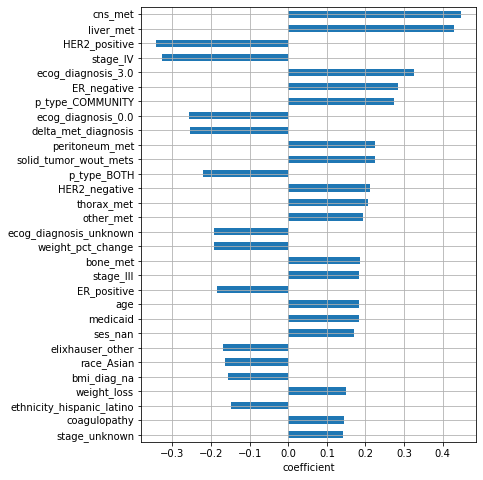

In [130]:
# Dataframe of coefficients for each variable 
coefficients_ridge = pd.DataFrame(
    ridge.named_steps['coxphsurvivalanalysis'].coef_,
    index = attributes,
    columns = ['coefficient']
)

print('Total number of features: {}'.format(len(attributes)))

non_zero = np.sum(coefficients_ridge.iloc[:, 0] != 0)
print('Number of non-zero features in final model: {}'.format(non_zero))

non_zero_coefs = coefficients_ridge.query('coefficient != 0')
coef_order = non_zero_coefs.abs().sort_values('coefficient').tail(30).index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax = ax, legend = False)
ax.set_xlabel('coefficient')
ax.grid(True)

### 4.2 LASSO

In [131]:
lasso = make_pipeline(preprocessor_red, CoxnetSurvivalAnalysis(l1_ratio = 1.0, alpha_min_ratio = 0.0001))

lasso.fit(train_x_red, train_y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'delta_met_diagnosis',
                                                   'weight_diag', 'bmi_diag',
                                                   'weight_pct_change',
                                                   'weight_slope',
                                                   'albumin_diag', 'alp_diag',
                                                   'alt_diag', 'ast_diag',
                                            

In [132]:
estimated_alphas = lasso.named_steps['coxnetsurvivalanalysis'].alphas_

In [133]:
estimated_alphas

array([1.52830631e-01, 1.39253579e-01, 1.26882675e-01, 1.15610768e-01,
       1.05340226e-01, 9.59820902e-02, 8.74553059e-02, 7.96860175e-02,
       7.26069314e-02, 6.61567317e-02, 6.02795500e-02, 5.49244809e-02,
       5.00451414e-02, 4.55992690e-02, 4.15483556e-02, 3.78573142e-02,
       3.44941747e-02, 3.14298073e-02, 2.86376699e-02, 2.60935782e-02,
       2.37754966e-02, 2.16633470e-02, 1.97388350e-02, 1.79852913e-02,
       1.63875276e-02, 1.49317048e-02, 1.36052133e-02, 1.23965637e-02,
       1.12952871e-02, 1.02918449e-02, 9.37754579e-03, 8.54447047e-03,
       7.78540326e-03, 7.09376949e-03, 6.46357856e-03, 5.88937206e-03,
       5.36617647e-03, 4.88946015e-03, 4.45509398e-03, 4.05931571e-03,
       3.69869729e-03, 3.37011522e-03, 3.07072347e-03, 2.79792886e-03,
       2.54936857e-03, 2.32288970e-03, 2.11653058e-03, 1.92850383e-03,
       1.75718087e-03, 1.60107776e-03, 1.45884243e-03, 1.32924289e-03,
       1.21115661e-03, 1.10356080e-03, 1.00552350e-03, 9.16195561e-04,
      

In [134]:
pipe = make_pipeline(preprocessor_red, CoxnetSurvivalAnalysis(l1_ratio = 1.0, max_iter = 100000))

# 5 fold cross-validation
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

# Parameter gird 
param_grid = {'estimator__coxnetsurvivalanalysis__alphas': [[x] for x in estimated_alphas]}

lasso_search = GridSearchCV(
    as_cumulative_dynamic_auc_scorer(pipe, 730),
    param_grid = param_grid,
    cv = cv,
    error_score = 0.5,
    n_jobs = -1,
    refit = False)

# Run search 
warnings.filterwarnings('ignore')
lasso_search.fit(train_x_red, train_y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score=0.5,
             estimator=as_cumulative_dynamic_auc_scorer(estimator=Pipeline(steps=[('columntransformer',
                                                                                   ColumnTransformer(remainder='passthrough',
                                                                                                     transformers=[('num',
                                                                                                                    Pipeline(steps=[('imputer',
                                                                                                                                     SimpleImputer(strategy='median')),
                                                                                                                                    ('std_scaler',
                                                                                  

In [135]:
lasso_search.best_params_

{'estimator__coxnetsurvivalanalysis__alphas': [0.0008348032725921575]}

In [136]:
best_lasso_alpha = lasso_search.best_params_.get('estimator__coxnetsurvivalanalysis__alphas')

In [137]:
lasso_search_results = pd.DataFrame(lasso_search.cv_results_)

In [138]:
lasso_search_results.sort_values(by = 'rank_test_score').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__coxnetsurvivalanalysis__alphas,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
56,2.737623,1.116293,0.100866,0.008366,[0.0008348032725921575],{'estimator__coxnetsurvivalanalysis__alphas': ...,0.778100,0.785550,0.788580,0.788143,0.793872,0.786849,0.005142,1
57,2.893630,1.264475,0.086698,0.014904,[0.0007606416506693003],{'estimator__coxnetsurvivalanalysis__alphas': ...,0.778011,0.785553,0.788333,0.788249,0.794048,0.786839,0.005211,2
55,2.552690,1.098665,0.090876,0.013730,[0.000916195561099456],{'estimator__coxnetsurvivalanalysis__alphas': ...,0.778167,0.785486,0.788817,0.787988,0.793706,0.786833,0.005088,3
58,3.013254,1.318337,0.092116,0.010506,[0.0006930683428400748],{'estimator__coxnetsurvivalanalysis__alphas': ...,0.777909,0.785551,0.788111,0.788372,0.794201,0.786829,0.005283,4
59,3.315732,1.502863,0.089195,0.012104,[0.0006314980614385573],{'estimator__coxnetsurvivalanalysis__alphas': ...,0.777787,0.785532,0.787922,0.788483,0.794267,0.786798,0.005342,5
54,2.418532,1.015666,0.073205,0.008858,[0.0010055234972568708],{'estimator__coxnetsurvivalanalysis__alphas': ...,0.778193,0.785482,0.789044,0.787818,0.793422,0.786792,0.005015,6
60,3.369291,1.483333,0.082478,0.020068,[0.0005753975141419445],{'estimator__coxnetsurvivalanalysis__alphas': ...,0.777705,0.785518,0.787748,0.788572,0.794295,0.786767,0.005377,7
61,3.788446,1.533265,0.093917,0.016396,[0.0005242807848475753],{'estimator__coxnetsurvivalanalysis__alphas': ...,0.777629,0.785517,0.787543,0.788659,0.794349,0.786739,0.005417,8
53,2.403997,1.010128,0.092106,0.026421,[0.001103560796913676],{'estimator__coxnetsurvivalanalysis__alphas': ...,0.778316,0.785508,0.789341,0.787470,0.793030,0.786733,0.004886,9
62,3.849936,1.464605,0.091649,0.020672,[0.0004777051249001085],{'estimator__coxnetsurvivalanalysis__alphas': ...,0.777551,0.785533,0.787287,0.788690,0.794337,0.786680,0.005435,10


In [139]:
lasso = make_pipeline(preprocessor_red, CoxnetSurvivalAnalysis(l1_ratio = 1.0, 
                                                               alphas = best_lasso_alpha,
                                                               max_iter = 100000))

lasso.fit(train_x_red, train_y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'delta_met_diagnosis',
                                                   'weight_diag', 'bmi_diag',
                                                   'weight_pct_change',
                                                   'weight_slope',
                                                   'albumin_diag', 'alp_diag',
                                                   'alt_diag', 'ast_diag',
                                            

In [140]:
lasso_risk_scores_te = lasso.predict(test_x_red)
lasso_auc_te = cumulative_dynamic_auc(train_y, test_y, lasso_risk_scores_te, 730)[0][0]
print('Test set AUC at 2 years:', lasso_auc_te)

Test set AUC at 2 years: 0.7858957204827764


In [141]:
lasso_risk_scores_tr = lasso.predict(train_x_red)
lasso_auc_tr = cumulative_dynamic_auc(train_y, train_y, lasso_risk_scores_tr, 730)[0][0]
print('Training set AUC at 2 years:', lasso_auc_tr)

Training set AUC at 2 years: 0.7908271109895335


In [142]:
# Bootstrap 10000 2-yr AUCs for test set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_te = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(lasso_risk_scores_te), len(lasso_risk_scores_te))
    auc_yr = cumulative_dynamic_auc(train_y, test_y[indices], lasso_risk_scores_te[indices], 730)[0][0]
    bootstrapped_scores_te.append(auc_yr)

In [143]:
# Standard error of mean for test set AUC
sorted_scores_te = np.array(bootstrapped_scores_te)
sorted_scores_te.sort()

conf_lower_te = sorted_scores_te[int(0.025 * len(sorted_scores_te))]
conf_upper_te = sorted_scores_te[int(0.975 * len(sorted_scores_te))]

standard_error_te = (conf_upper_te - conf_lower_te) / 3.92
print('Test set AUC standard error:', standard_error_te)

Test set AUC standard error: 0.006562578384422904


In [144]:
# Bootstrap 10000 3-yr AUCs for train set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_tr = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(lasso_risk_scores_tr), len(lasso_risk_scores_tr))
    auc_yr = cumulative_dynamic_auc(train_y, train_y[indices], lasso_risk_scores_tr[indices], 730)[0][0]
    bootstrapped_scores_tr.append(auc_yr)

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:394: UserWarning: all coefficients are zero, consider decreasing alpha.
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:394: UserWarning: all coefficients are zero, consider decreasing alpha.
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


In [145]:
# Standard error of mean for train set AUC
sorted_scores_tr = np.array(bootstrapped_scores_tr)
sorted_scores_tr.sort()

conf_lower_tr = sorted_scores_tr[int(0.025 * len(sorted_scores_tr))]
conf_upper_tr = sorted_scores_tr[int(0.975 * len(sorted_scores_tr))]

standard_error_tr = (conf_upper_tr - conf_lower_tr) / 3.92
print('Training set AUC standard error', standard_error_tr)

Training set AUC standard error 0.0032938731058784585


In [146]:
crude_auc_data = {'model': 'lasso_crude',
                  'auc_2yr_te': lasso_auc_te,
                  'sem_te': standard_error_te,
                  'auc_2yr_tr': lasso_auc_tr,
                  'sem_tr': standard_error_tr}

In [147]:
crude_auc_df = pd.read_csv('crude_auc_df.csv')

In [148]:
crude_auc_df = crude_auc_df.append(crude_auc_data, ignore_index = True)

In [149]:
crude_auc_df

,model,auc_2yr_te,sem_te,auc_2yr_tr,sem_tr
0,gbm_crude,0.817707,0.005979,0.849410,0.002789
1,rsf_crude,0.797620,0.006318,0.916818,0.001940
2,ridge_crude,0.785537,0.006508,0.789876,0.003292
3,lasso_crude,0.785896,0.006563,0.790827,0.003294


In [150]:
crude_auc_df.to_csv('crude_auc_df.csv', index = False, header = True)

In [151]:
times = np.arange(30, 1810, 30)
crude_lasso_auc_over5 = cumulative_dynamic_auc(train_y, test_y, lasso_risk_scores_te, times)[0]

times_data = {}
values = crude_lasso_auc_over5
time_names = []

for x in range(len(times)):
    time_names.append('time_'+str(times[x]))

for i in range(len(time_names)):
    times_data[time_names[i]] = values[i]
    
crude_lasso_over5_df = pd.DataFrame(times_data, index = ['lasso_crude'])

In [152]:
crude_auc_over5 = pd.read_csv('crude_auc_over5.csv', index_col = 0)

In [153]:
crude_auc_over5 = crude_auc_over5.append(crude_lasso_over5_df, ignore_index = False)

In [154]:
crude_auc_over5

,time_30,time_60,time_90,time_120,time_150,time_180,time_210,time_240,time_270,time_300,...,time_1530,time_1560,time_1590,time_1620,time_1650,time_1680,time_1710,time_1740,time_1770,time_1800
gbm_crude,0.865653,0.884240,0.866949,0.865569,0.861561,0.852376,0.852850,0.850731,0.851161,0.849431,...,0.782725,0.779661,0.781463,0.781015,0.779310,0.779304,0.777667,0.776433,0.776933,0.776247
rsf_crude,0.866668,0.876143,0.852497,0.850469,0.846343,0.836480,0.835673,0.831395,0.830522,0.829236,...,0.763159,0.759102,0.761464,0.761499,0.757960,0.756729,0.756293,0.756140,0.755578,0.754173
ridge_crude,0.847699,0.851870,0.835914,0.829498,0.825503,0.815028,0.814743,0.813877,0.815353,0.812816,...,0.757919,0.755934,0.757266,0.759101,0.758257,0.756038,0.754627,0.752895,0.754179,0.755089
lasso_crude,0.844126,0.849688,0.833727,0.828378,0.825278,0.815491,0.815472,0.814085,0.815791,0.813255,...,0.757880,0.756026,0.757339,0.759036,0.758399,0.756208,0.754680,0.753027,0.754558,0.755559


In [155]:
crude_auc_over5.to_csv('crude_auc_over5.csv', index = True, header = True)

In [156]:
# Variables passing through pipeline
cat_encoder = list(preprocessor_red.transformers_[1][1].get_feature_names(categorical_features))
pass_through = list(train_x_red.iloc[:, preprocessor_red.transformers_[2][2]].columns)
attributes = numerical_features_red + cat_encoder + pass_through

Total number of features: 195
Number of non-zero features in final model: 116


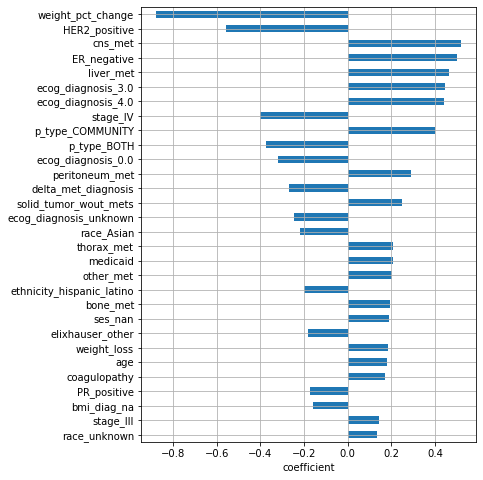

In [157]:
# Dataframe of coefficients for each variable 
coefficients_lasso = pd.DataFrame(
    lasso.named_steps['coxnetsurvivalanalysis'].coef_,
    index = attributes,
    columns = ['coefficient']
)

print('Total number of features: {}'.format(len(attributes)))

non_zero = np.sum(coefficients_lasso.iloc[:, 0] != 0)
print('Number of non-zero features in final model: {}'.format(non_zero))

non_zero_coefs = coefficients_lasso.query('coefficient != 0')
coef_order = non_zero_coefs.abs().sort_values('coefficient').tail(30).index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax = ax, legend = False)
ax.set_xlabel('coefficient')
ax.grid(True)

### 4.3 Elastic net 

In [158]:
enet = make_pipeline(preprocessor_red, CoxnetSurvivalAnalysis(l1_ratio = 0.8, alpha_min_ratio = 0.0001))

enet.fit(train_x_red, train_y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'delta_met_diagnosis',
                                                   'weight_diag', 'bmi_diag',
                                                   'weight_pct_change',
                                                   'weight_slope',
                                                   'albumin_diag', 'alp_diag',
                                                   'alt_diag', 'ast_diag',
                                            

In [159]:
enet.named_steps['coxnetsurvivalanalysis'].alphas_

array([1.91038288e-01, 1.74066973e-01, 1.58603343e-01, 1.44513459e-01,
       1.31675282e-01, 1.19977613e-01, 1.09319132e-01, 9.96075219e-02,
       9.07586642e-02, 8.26959146e-02, 7.53494375e-02, 6.86556011e-02,
       6.25564268e-02, 5.69990862e-02, 5.19354445e-02, 4.73216427e-02,
       4.31177184e-02, 3.92872592e-02, 3.57970873e-02, 3.26169728e-02,
       2.97193708e-02, 2.70791838e-02, 2.46735437e-02, 2.24816141e-02,
       2.04844095e-02, 1.86646310e-02, 1.70065166e-02, 1.54957046e-02,
       1.41191089e-02, 1.28648062e-02, 1.17219322e-02, 1.06805881e-02,
       9.73175408e-03, 8.86721186e-03, 8.07947320e-03, 7.36171507e-03,
       6.70772059e-03, 6.11182518e-03, 5.56886748e-03, 5.07414464e-03,
       4.62337162e-03, 4.21264402e-03, 3.83840434e-03, 3.49741108e-03,
       3.18671072e-03, 2.90361212e-03, 2.64566322e-03, 2.41062979e-03,
       2.19647609e-03, 2.00134720e-03, 1.82355303e-03, 1.66155361e-03,
       1.51394577e-03, 1.37945100e-03, 1.25690437e-03, 1.14524445e-03,
      

In [160]:
estimated_alphas = enet.named_steps['coxnetsurvivalanalysis'].alphas_

In [161]:
pipe = make_pipeline(preprocessor_red, CoxnetSurvivalAnalysis(l1_ratio = 0.9, max_iter = 100000))

# 5 fold cross-validation
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

# Parameter gird 
param_grid = {'estimator__coxnetsurvivalanalysis__alphas': [[x] for x in estimated_alphas]}

enet_search = GridSearchCV(
    as_cumulative_dynamic_auc_scorer(pipe, 730),
    param_grid = param_grid,
    cv = cv,
    error_score = 0.5,
    n_jobs = -1,
    refit = False)

# Run search 
warnings.filterwarnings('ignore')
enet_search.fit(train_x_red, train_y)

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:394: UserWarning: all coefficients are zero, consider decreasing alpha.
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score=0.5,
             estimator=as_cumulative_dynamic_auc_scorer(estimator=Pipeline(steps=[('columntransformer',
                                                                                   ColumnTransformer(remainder='passthrough',
                                                                                                     transformers=[('num',
                                                                                                                    Pipeline(steps=[('imputer',
                                                                                                                                     SimpleImputer(strategy='median')),
                                                                                                                                    ('std_scaler',
                                                                                  

In [162]:
enet_search.best_params_

{'estimator__coxnetsurvivalanalysis__alphas': [0.0009508020633366257]}

In [163]:
best_enet_alpha = enet_search.best_params_.get('estimator__coxnetsurvivalanalysis__alphas')

In [164]:
enet_search_results = pd.DataFrame(enet_search.cv_results_)

In [165]:
enet_search_results.sort_values(by = 'rank_test_score').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__coxnetsurvivalanalysis__alphas,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
57,2.047803,0.967821,0.068946,0.014817,[0.0009508020633366257],{'estimator__coxnetsurvivalanalysis__alphas': ...,0.778195,0.785502,0.788670,0.787958,0.793750,0.786815,0.005077,1
56,2.004508,0.887243,0.065650,0.016487,[0.0010435040907401973],{'estimator__coxnetsurvivalanalysis__alphas': ...,0.778259,0.785440,0.788920,0.787821,0.793571,0.786802,0.005023,2
58,2.261800,0.975523,0.075735,0.014043,[0.0008663354285500938],{'estimator__coxnetsurvivalanalysis__alphas': ...,0.778111,0.785499,0.788408,0.788064,0.793914,0.786799,0.005138,3
59,2.259099,1.058197,0.066270,0.007055,[0.000789372576798197],{'estimator__coxnetsurvivalanalysis__alphas': ...,0.778038,0.785471,0.788165,0.788192,0.794089,0.786791,0.005205,4
60,2.397942,1.156095,0.075159,0.014053,[0.0007192468926774309],{'estimator__coxnetsurvivalanalysis__alphas': ...,0.777886,0.785461,0.788004,0.788329,0.794158,0.786768,0.005276,5
55,1.924336,0.916075,0.068441,0.017976,[0.0011452444513743204],{'estimator__coxnetsurvivalanalysis__alphas': ...,0.778297,0.785448,0.789207,0.787597,0.793224,0.786755,0.004936,6
61,2.690349,1.362531,0.068487,0.011792,[0.0006553509810594694],{'estimator__coxnetsurvivalanalysis__alphas': ...,0.777807,0.785447,0.787796,0.788443,0.794237,0.786746,0.005323,7
62,2.857391,1.440786,0.057884,0.011748,[0.0005971314061251359],{'estimator__coxnetsurvivalanalysis__alphas': ...,0.777690,0.785473,0.787607,0.788506,0.794272,0.786710,0.005369,8
54,1.732264,0.846222,0.067193,0.010994,[0.0012569043715710889],{'estimator__coxnetsurvivalanalysis__alphas': ...,0.778365,0.785451,0.789450,0.787243,0.792907,0.786683,0.004846,9
63,2.846187,1.070318,0.075547,0.012234,[0.0005440838977680964],{'estimator__coxnetsurvivalanalysis__alphas': ...,0.777606,0.785497,0.787384,0.788551,0.794309,0.786669,0.005403,10


In [166]:
enet = make_pipeline(preprocessor_red, CoxnetSurvivalAnalysis(l1_ratio = 0.8,
                                                              alphas = best_enet_alpha,
                                                              max_iter = 100000))

enet.fit(train_x_red, train_y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'delta_met_diagnosis',
                                                   'weight_diag', 'bmi_diag',
                                                   'weight_pct_change',
                                                   'weight_slope',
                                                   'albumin_diag', 'alp_diag',
                                                   'alt_diag', 'ast_diag',
                                            

In [167]:
enet_risk_scores_te = enet.predict(test_x_red)
enet_auc_te = cumulative_dynamic_auc(train_y, test_y, enet_risk_scores_te, 730)[0][0]
print('Test set AUC at 2 years:', enet_auc_te)

Test set AUC at 2 years: 0.7857219682916713


In [168]:
enet_risk_scores_tr = enet.predict(train_x_red)
enet_auc_tr = cumulative_dynamic_auc(train_y, train_y, enet_risk_scores_tr, 730)[0][0]
print('Training set AUC at 2 years:', enet_auc_tr)

Training set AUC at 2 years: 0.7907478833548364


In [169]:
# Bootstrap 10000 2-yr AUCs for test set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_te = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(enet_risk_scores_te), len(enet_risk_scores_te))
    auc_yr = cumulative_dynamic_auc(train_y, test_y[indices], enet_risk_scores_te[indices], 730)[0][0]
    bootstrapped_scores_te.append(auc_yr)

In [170]:
# Standard error of mean for test set AUC
sorted_scores_te = np.array(bootstrapped_scores_te)
sorted_scores_te.sort()

conf_lower_te = sorted_scores_te[int(0.025 * len(sorted_scores_te))]
conf_upper_te = sorted_scores_te[int(0.975 * len(sorted_scores_te))]

standard_error_te = (conf_upper_te - conf_lower_te) / 3.92
print('Test set AUC standard error:', standard_error_te)

Test set AUC standard error: 0.006574166603472295


In [171]:
# Bootstrap 10000 2-yr AUCs for train set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_tr = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(enet_risk_scores_tr), len(enet_risk_scores_tr))
    auc_yr = cumulative_dynamic_auc(train_y, train_y[indices], enet_risk_scores_tr[indices], 730)[0][0]
    bootstrapped_scores_tr.append(auc_yr)

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:394: UserWarning: all coefficients are zero, consider decreasing alpha.
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:394: UserWarning: all coefficients are zero, consider decreasing alpha.
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:394: UserWarning: all coefficients are zero, consider decreasing alpha.
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:394: UserWarning: all coefficients are zero, consider decreasing alpha.
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:394: UserWarning: all coefficients are zero, consider decreasing alpha.
  self._final_estimator.fit(Xt, y, **fit_par

In [172]:
# Standard error of mean for train set AUC
sorted_scores_tr = np.array(bootstrapped_scores_tr)
sorted_scores_tr.sort()

conf_lower_tr = sorted_scores_tr[int(0.025 * len(sorted_scores_tr))]
conf_upper_tr = sorted_scores_tr[int(0.975 * len(sorted_scores_tr))]

standard_error_tr = (conf_upper_tr - conf_lower_tr) / 3.92
print('Training set AUC standard error', standard_error_tr)

Training set AUC standard error 0.00329883997818898


In [173]:
crude_auc_data = {'model': 'enet_crude',
                  'auc_2yr_te': enet_auc_te,
                  'sem_te': standard_error_te,
                  'auc_2yr_tr': enet_auc_tr,
                  'sem_tr': standard_error_tr}

In [174]:
crude_auc_df = pd.read_csv('crude_auc_df.csv')

In [175]:
crude_auc_df = crude_auc_df.append(crude_auc_data, ignore_index = True)

In [176]:
crude_auc_df

,model,auc_2yr_te,sem_te,auc_2yr_tr,sem_tr
0,gbm_crude,0.817707,0.005979,0.849410,0.002789
1,rsf_crude,0.797620,0.006318,0.916818,0.001940
2,ridge_crude,0.785537,0.006508,0.789876,0.003292
3,lasso_crude,0.785896,0.006563,0.790827,0.003294
4,enet_crude,0.785722,0.006574,0.790748,0.003299


In [177]:
crude_auc_df.to_csv('crude_auc_df.csv', index = False, header = True)

In [178]:
times = np.arange(30, 1810, 30)
crude_enet_auc_over5 = cumulative_dynamic_auc(train_y, test_y, enet_risk_scores_te, times)[0]

times_data = {}
values = crude_enet_auc_over5
time_names = []

for x in range(len(times)):
    time_names.append('time_'+str(times[x]))

for i in range(len(time_names)):
    times_data[time_names[i]] = values[i]
    
crude_enet_over5_df = pd.DataFrame(times_data, index = ['enet_crude'])

In [179]:
crude_auc_over5 = pd.read_csv('crude_auc_over5.csv', index_col = 0)

In [180]:
crude_auc_over5 = crude_auc_over5.append(crude_enet_over5_df, ignore_index = False)

In [181]:
crude_auc_over5

,time_30,time_60,time_90,time_120,time_150,time_180,time_210,time_240,time_270,time_300,...,time_1530,time_1560,time_1590,time_1620,time_1650,time_1680,time_1710,time_1740,time_1770,time_1800
gbm_crude,0.865653,0.884240,0.866949,0.865569,0.861561,0.852376,0.852850,0.850731,0.851161,0.849431,...,0.782725,0.779661,0.781463,0.781015,0.779310,0.779304,0.777667,0.776433,0.776933,0.776247
rsf_crude,0.866668,0.876143,0.852497,0.850469,0.846343,0.836480,0.835673,0.831395,0.830522,0.829236,...,0.763159,0.759102,0.761464,0.761499,0.757960,0.756729,0.756293,0.756140,0.755578,0.754173
ridge_crude,0.847699,0.851870,0.835914,0.829498,0.825503,0.815028,0.814743,0.813877,0.815353,0.812816,...,0.757919,0.755934,0.757266,0.759101,0.758257,0.756038,0.754627,0.752895,0.754179,0.755089
lasso_crude,0.844126,0.849688,0.833727,0.828378,0.825278,0.815491,0.815472,0.814085,0.815791,0.813255,...,0.757880,0.756026,0.757339,0.759036,0.758399,0.756208,0.754680,0.753027,0.754558,0.755559
enet_crude,0.844331,0.849965,0.833969,0.828462,0.825266,0.815389,0.815344,0.813974,0.815661,0.813060,...,0.757832,0.755988,0.757300,0.759021,0.758378,0.756192,0.754681,0.753018,0.754557,0.755562


In [182]:
crude_auc_over5.to_csv('crude_auc_over5.csv', index = True, header = True)

In [183]:
# Variables passing through pipeline
cat_encoder = list(preprocessor_red.transformers_[1][1].get_feature_names(categorical_features))
pass_through = list(train_x_red.iloc[:, preprocessor_red.transformers_[2][2]].columns)
attributes = numerical_features_red + cat_encoder + pass_through

Total number of features: 195
Number of non-zero features in final model: 118


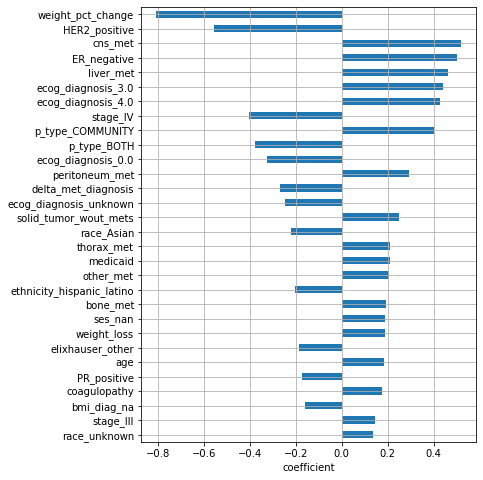

In [184]:
# Dataframe of coefficients for each variable 
coefficients_enet = pd.DataFrame(
    enet.named_steps['coxnetsurvivalanalysis'].coef_,
    index = attributes,
    columns = ['coefficient']
)

print('Total number of features: {}'.format(len(attributes)))

non_zero = np.sum(coefficients_enet.iloc[:, 0] != 0)
print('Number of non-zero features in final model: {}'.format(non_zero))

non_zero_coefs = coefficients_enet.query('coefficient != 0')
coef_order = non_zero_coefs.abs().sort_values('coefficient').tail(30).index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax = ax, legend = False)
ax.set_xlabel('coefficient')
ax.grid(True)

**Among the penalized Cox models, the LASSO penalty has the best performance in regards to test set 2 year AUC. Not surprisingly, the penalized Cox models perform worse than the gradient boosting model or the random survival forest.**

## 5. Linear survival support vector machine 

**Lastly, we'll build a survival support vector machines with a linear kernel and a ranking objective.** 

In [185]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import make_pipeline

from sksurv.svm import FastSurvivalSVM
from sksurv.metrics import cumulative_dynamic_auc, as_cumulative_dynamic_auc_scorer

import warnings 

import matplotlib.pyplot as plt

In [186]:
pipe = make_pipeline(preprocessor_red, FastSurvivalSVM(rank_ratio = 1, 
                                                       max_iter = 1000, 
                                                       tol = 1e-3,
                                                       random_state = 42))

# 3 fold cross-validation
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

# Parameter gird 
param_grid = {'estimator__fastsurvivalsvm__alpha': 10. ** np.linspace(-3, 3, 15)}

linear_svm_search = GridSearchCV(
    as_cumulative_dynamic_auc_scorer(pipe, 730),
    param_grid = param_grid,
    cv = cv,
    error_score = 0.5,
    n_jobs = -1,
    refit = False)

# Run search 
warnings.filterwarnings('ignore')
linear_svm_search.fit(train_x_red, train_y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score=0.5,
             estimator=as_cumulative_dynamic_auc_scorer(estimator=Pipeline(steps=[('columntransformer',
                                                                                   ColumnTransformer(remainder='passthrough',
                                                                                                     transformers=[('num',
                                                                                                                    Pipeline(steps=[('imputer',
                                                                                                                                     SimpleImputer(strategy='median')),
                                                                                                                                    ('std_scaler',
                                                                                  

In [187]:
linear_svm_search.best_params_

{'estimator__fastsurvivalsvm__alpha': 138.9495494373136}

In [188]:
best_linear_svm_alpha = linear_svm_search.best_params_.get('estimator__fastsurvivalsvm__alpha')

In [189]:
linear_svm_search_results = pd.DataFrame(linear_svm_search.cv_results_)

In [190]:
linear_svm_search_results.sort_values(by = 'rank_test_score').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__fastsurvivalsvm__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
12,107.790888,17.221268,0.125224,0.015108,138.949549,{'estimator__fastsurvivalsvm__alpha': 138.9495...,0.780384,0.787706,0.788041,0.791850,0.799112,0.789419,0.006105,1
11,98.206453,12.995368,0.122200,0.010632,51.794747,{'estimator__fastsurvivalsvm__alpha': 51.79474...,0.780377,0.787711,0.788038,0.791851,0.799094,0.789414,0.006101,2
14,81.608658,14.019787,0.056745,0.011890,1000.0,{'estimator__fastsurvivalsvm__alpha': 1000.0},0.780376,0.787711,0.788042,0.791848,0.799093,0.789414,0.006101,3
1,63.095614,12.527972,0.129396,0.069777,0.002683,{'estimator__fastsurvivalsvm__alpha': 0.002682...,0.780379,0.787712,0.788046,0.791838,0.799093,0.789414,0.006098,4
2,64.254838,11.235878,0.085950,0.038079,0.007197,{'estimator__fastsurvivalsvm__alpha': 0.007196...,0.780383,0.787705,0.788044,0.791816,0.799103,0.789410,0.006099,5
10,108.369802,13.773738,0.128610,0.017457,19.306977,{'estimator__fastsurvivalsvm__alpha': 19.30697...,0.780377,0.787709,0.788040,0.791850,0.799067,0.789409,0.006092,6
7,68.144573,11.917274,0.068775,0.031020,1.0,{'estimator__fastsurvivalsvm__alpha': 1.0},0.780386,0.787706,0.788043,0.791837,0.799064,0.789407,0.006088,7
0,70.089742,14.799423,0.129596,0.142375,0.001,{'estimator__fastsurvivalsvm__alpha': 0.001},0.780385,0.787706,0.788048,0.791844,0.799050,0.789407,0.006084,8
8,79.988440,5.248774,0.098803,0.036607,2.682696,{'estimator__fastsurvivalsvm__alpha': 2.682695...,0.780383,0.787711,0.788032,0.791838,0.799063,0.789405,0.006089,9
3,70.065421,9.927468,0.047167,0.020439,0.019307,{'estimator__fastsurvivalsvm__alpha': 0.019306...,0.780413,0.787699,0.788033,0.791814,0.799063,0.789404,0.006078,10


In [191]:
linear_svm = make_pipeline(preprocessor_red, FastSurvivalSVM(alpha = best_linear_svm_alpha,
                                                             rank_ratio = 1,
                                                             max_iter = 1000,
                                                             tol = 1e-3,
                                                             random_state = 42))

linear_svm.fit(train_x_red, train_y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'delta_met_diagnosis',
                                                   'weight_diag', 'bmi_diag',
                                                   'weight_pct_change',
                                                   'weight_slope',
                                                   'albumin_diag', 'alp_diag',
                                                   'alt_diag', 'ast_diag',
                                            

In [192]:
linear_svm_risk_scores_te = linear_svm.predict(test_x_red)
linear_svm_auc_te = cumulative_dynamic_auc(train_y, test_y, linear_svm_risk_scores_te, 730)[0][0]
print('Test set AUC at 2 years:', linear_svm_auc_te)

Test set AUC at 2 years: 0.7874044949858581


In [193]:
linear_svm_risk_scores_tr = linear_svm.predict(train_x_red)
linear_svm_auc_tr = cumulative_dynamic_auc(train_y, train_y, linear_svm_risk_scores_tr, 730)[0][0]
print('Training set AUC at 2 years:', linear_svm_auc_tr)

Training set AUC at 2 years: 0.7954677138547733


In [194]:
# Bootstrap 10000 2-yr AUCs for test set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_te = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(linear_svm_risk_scores_te), len(linear_svm_risk_scores_te))
    auc_yr = cumulative_dynamic_auc(train_y, test_y[indices], linear_svm_risk_scores_te[indices], 730)[0][0]
    bootstrapped_scores_te.append(auc_yr)

In [195]:
# Standard error of mean for test set AUC
sorted_scores_te = np.array(bootstrapped_scores_te)
sorted_scores_te.sort()

conf_lower_te = sorted_scores_te[int(0.025 * len(sorted_scores_te))]
conf_upper_te = sorted_scores_te[int(0.975 * len(sorted_scores_te))]

standard_error_te = (conf_upper_te - conf_lower_te) / 3.92
print('Test set AUC standard error:', standard_error_te)

Test set AUC standard error: 0.006497163607994649


In [196]:
# Bootstrap 10000 2-yr AUCs for train set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_tr = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(linear_svm_risk_scores_tr), len(linear_svm_risk_scores_tr))
    auc_yr = cumulative_dynamic_auc(train_y, train_y[indices], linear_svm_risk_scores_tr[indices], 730)[0][0]
    bootstrapped_scores_tr.append(auc_yr)

In [197]:
# Standard error of mean for train set AUC
sorted_scores_tr = np.array(bootstrapped_scores_tr)
sorted_scores_tr.sort()

conf_lower_tr = sorted_scores_tr[int(0.025 * len(sorted_scores_tr))]
conf_upper_tr = sorted_scores_tr[int(0.975 * len(sorted_scores_tr))]

standard_error_tr = (conf_upper_tr - conf_lower_tr) / 3.92
print('Training set AUC standard error', standard_error_tr)

Training set AUC standard error 0.003280151018591091


In [198]:
crude_auc_data = {'model': 'linear_svm_crude',
                  'auc_2yr_te': linear_svm_auc_te,
                  'sem_te': standard_error_te,
                  'auc_2yr_tr': linear_svm_auc_tr,
                  'sem_tr': standard_error_tr}

In [199]:
crude_auc_df = pd.read_csv('crude_auc_df.csv')

In [200]:
crude_auc_df = crude_auc_df.append(crude_auc_data, ignore_index = True)

In [201]:
crude_auc_df.sort_values(by = 'auc_2yr_te', ascending = False)

,model,auc_2yr_te,sem_te,auc_2yr_tr,sem_tr
0,gbm_crude,0.817707,0.005979,0.849410,0.002789
1,rsf_crude,0.797620,0.006318,0.916818,0.001940
5,linear_svm_crude,0.787404,0.006497,0.795468,0.003280
3,lasso_crude,0.785896,0.006563,0.790827,0.003294
4,enet_crude,0.785722,0.006574,0.790748,0.003299
2,ridge_crude,0.785537,0.006508,0.789876,0.003292


In [202]:
crude_auc_df.to_csv('crude_auc_df.csv', index = False, header = True)

In [203]:
times = np.arange(30, 1810, 30)
crude_linear_svm_auc_over5 = cumulative_dynamic_auc(train_y, test_y, linear_svm_risk_scores_te, times)[0]

times_data = {}
values = crude_linear_svm_auc_over5
time_names = []

for x in range(len(times)):
    time_names.append('time_'+str(times[x]))

for i in range(len(time_names)):
    times_data[time_names[i]] = values[i]
    
crude_linear_svm_over5_df = pd.DataFrame(times_data, index = ['linear_svm_crude'])

In [204]:
crude_auc_over5 = pd.read_csv('crude_auc_over5.csv', index_col = 0)

In [205]:
crude_auc_over5 = crude_auc_over5.append(crude_linear_svm_over5_df, ignore_index = False)

In [206]:
crude_auc_over5

,time_30,time_60,time_90,time_120,time_150,time_180,time_210,time_240,time_270,time_300,...,time_1530,time_1560,time_1590,time_1620,time_1650,time_1680,time_1710,time_1740,time_1770,time_1800
gbm_crude,0.865653,0.884240,0.866949,0.865569,0.861561,0.852376,0.852850,0.850731,0.851161,0.849431,...,0.782725,0.779661,0.781463,0.781015,0.779310,0.779304,0.777667,0.776433,0.776933,0.776247
rsf_crude,0.866668,0.876143,0.852497,0.850469,0.846343,0.836480,0.835673,0.831395,0.830522,0.829236,...,0.763159,0.759102,0.761464,0.761499,0.757960,0.756729,0.756293,0.756140,0.755578,0.754173
ridge_crude,0.847699,0.851870,0.835914,0.829498,0.825503,0.815028,0.814743,0.813877,0.815353,0.812816,...,0.757919,0.755934,0.757266,0.759101,0.758257,0.756038,0.754627,0.752895,0.754179,0.755089
lasso_crude,0.844126,0.849688,0.833727,0.828378,0.825278,0.815491,0.815472,0.814085,0.815791,0.813255,...,0.757880,0.756026,0.757339,0.759036,0.758399,0.756208,0.754680,0.753027,0.754558,0.755559
enet_crude,0.844331,0.849965,0.833969,0.828462,0.825266,0.815389,0.815344,0.813974,0.815661,0.813060,...,0.757832,0.755988,0.757300,0.759021,0.758378,0.756192,0.754681,0.753018,0.754557,0.755562
linear_svm_crude,0.851887,0.854559,0.840842,0.832875,0.829001,0.818959,0.819477,0.818379,0.819659,0.816472,...,0.759167,0.757604,0.759548,0.761481,0.760706,0.758725,0.757701,0.755718,0.757699,0.758888


In [207]:
crude_auc_over5.to_csv('crude_auc_over5.csv', index = True, header = True)

In [208]:
# Variables passing through pipeline
cat_encoder = list(preprocessor_red.transformers_[1][1].get_feature_names_out(categorical_features))
pass_through = list(train_x_red.iloc[:, preprocessor_red.transformers_[2][2]].columns)
attributes = numerical_features_red + cat_encoder + pass_through

Total number of features: 195
Number of non-zero features in final model: 195


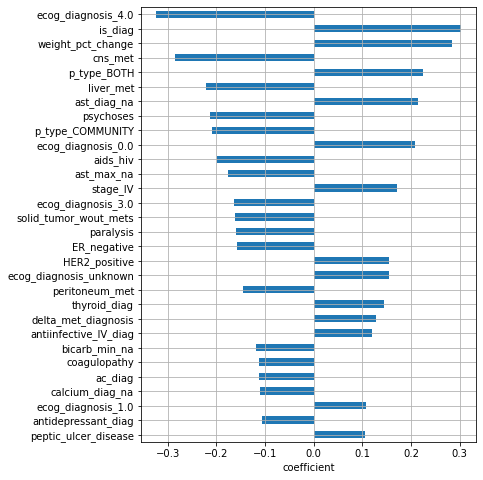

In [209]:
# Dataframe of coefficients for each variable 
coefficients_linear_svm = pd.DataFrame(
    linear_svm.named_steps['fastsurvivalsvm'].coef_,
    index = attributes,
    columns = ['coefficient']
)

print('Total number of features: {}'.format(len(attributes)))

non_zero = np.sum(coefficients_linear_svm.iloc[:, 0] != 0)
print('Number of non-zero features in final model: {}'.format(non_zero))

non_zero_coefs = coefficients_linear_svm.query('coefficient != 0')
coef_order = non_zero_coefs.abs().sort_values('coefficient').tail(30).index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax = ax, legend = False)
ax.set_xlabel('coefficient')
ax.grid(True)

**In conclusion, the gradient boosted model has the best test set performance in regards to 2 year AUC. Random survival forest follows closely behind. The bottom performers are penalized Cox and linear survival support vector machine.** 